### Setup and Imports

In [100]:
!pip3 install -r ../requirements.txt

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      error in googleads setup command: use_2to3 is invalid.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached parselmouth-1.1.1.tar.gz (33 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached googleads-3.8.0.tar.gz (23 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


In [104]:
import numpy as np
import pandas as pd
import librosa
# from model import ridge_based_brute_linear_regression, collinearity_based_brute_linear_regression  # Importing the custom developed linear regression model based on the matrix approach to utilize for model training process
# # Currently, the implementation of the respective model has been integrating into this notebook for avoid any module based anamolies; whereas in order to better code based modularity this approach is more preferred

# Utility imports
import parselmouth
import io
import os
import tempfile
import pydub
from mutagen.mp3 import MP3
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import noisereduce as nr
from tqdm.notebook import tqdm_notebook
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Loading the Training Data

In [4]:
truncated_train = pd.read_csv("..\\dataset\\truncated_train_metadata.csv")

### EDA: For, initial state of the training dataset

In [5]:
truncated_train.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,train/cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,train/cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,train/cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,train/cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,train/cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [6]:
truncated_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15001 entries, 0 to 15000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    15001 non-null  object 
 1   text        15001 non-null  object 
 2   up_votes    15001 non-null  int64  
 3   down_votes  15001 non-null  int64  
 4   age         5615 non-null   object 
 5   gender      5626 non-null   object 
 6   accent      4933 non-null   object 
 7   duration    0 non-null      float64
dtypes: float64(1), int64(2), object(5)
memory usage: 937.7+ KB


In [7]:
truncated_train.describe()

,up_votes,down_votes,duration
count,15001.000000,15001.000000,0.0
mean,2.545964,0.179788,NaN
std,7.579492,4.377489,NaN
min,1.000000,0.000000,NaN
25%,1.000000,0.000000,NaN
50%,2.000000,0.000000,NaN
75%,3.000000,0.000000,NaN
max,745.000000,528.000000,NaN


In [8]:
truncated_train.isnull().sum()

filename          0
text              0
up_votes          0
down_votes        0
age            9386
gender         9375
accent        10068
duration      15001
dtype: int64

### Data Visualization: For the initial state of the training dataset

In [10]:
features_to_plot = ['up_votes', 'down_votes', 'age', 'gender', 'accent']

num_features = len(features_to_plot)
ncols = 2
nrows = math.ceil(num_features / ncols)

figsize = (ncols * 5, nrows * 5)

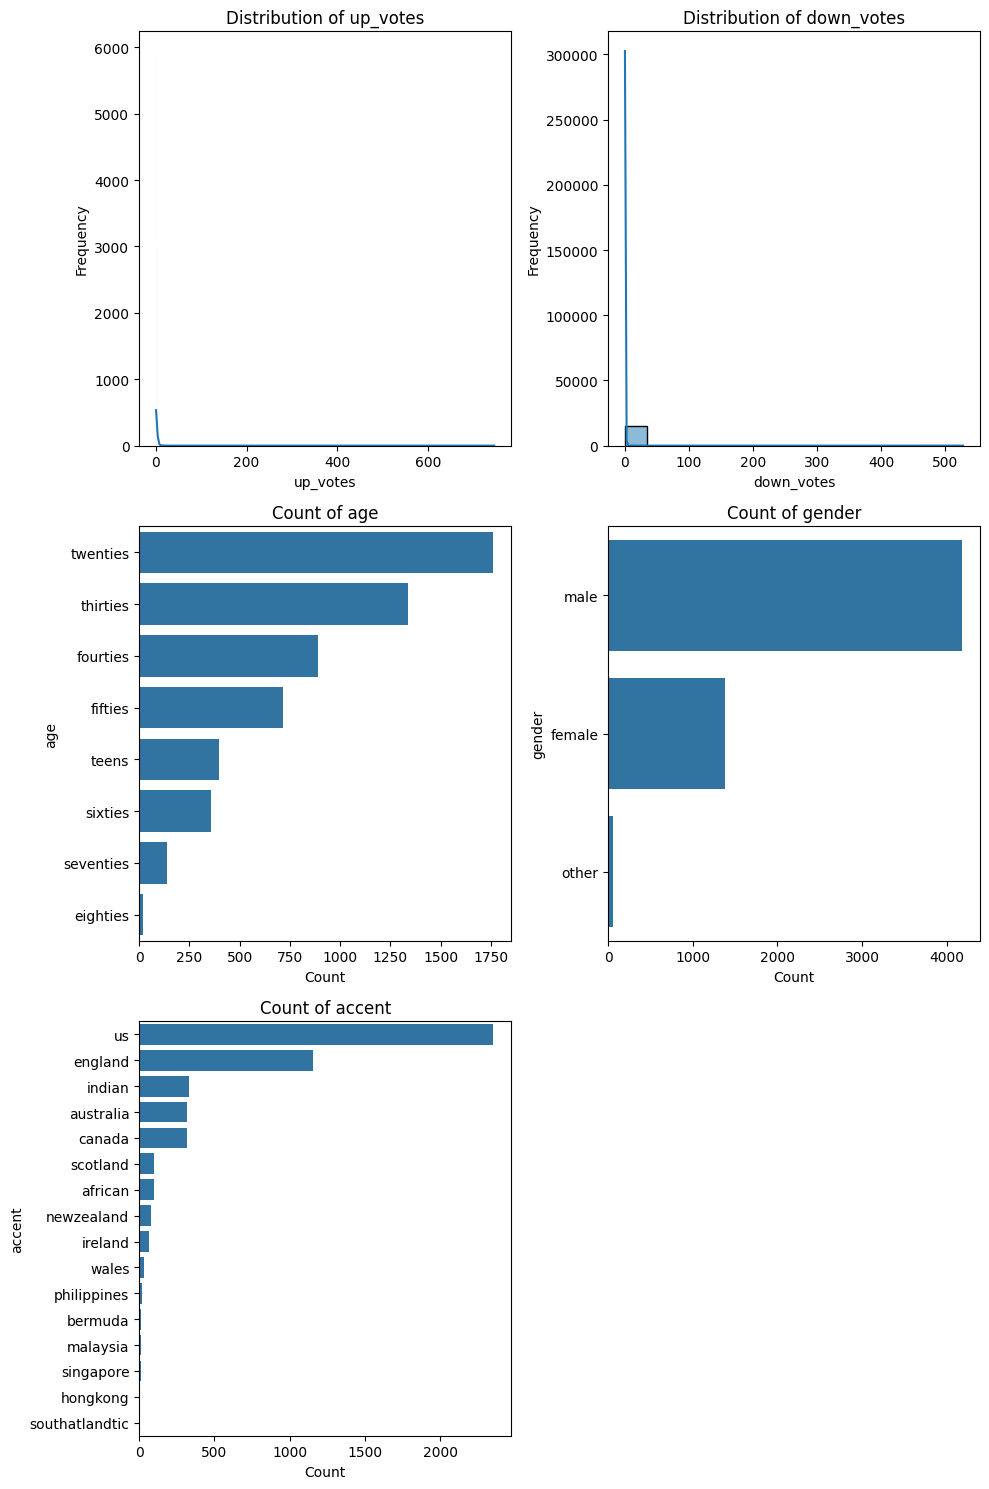

In [11]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    
    if truncated_train[feature].dtype in [np.int64, np.float64]:  # Numerical features
        sns.histplot(truncated_train[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
    else:  # Categorical features
        sns.countplot(y=truncated_train[feature], ax=axes[i], order=truncated_train[feature].value_counts().index)
        axes[i].set_title(f'Count of {feature}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(feature)

# Removing any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### (Audio) Feature Extraction

#### > Utility functions for feature extraction process:

**Note:** Through the EDA of initial (original) state of the dataset; there happened to be no missing values within the column that contained the paths to the audio files. Therefore, it is safe to proceed towards feature extraction for the audio files and maintaining a training dataset for training the respective regression model.

In [13]:
def resize_spectrogram(spec, length, fact=-80):

    # Creating an empty canvas to put spectrogram into
    canvas = np.ones((len(spec), length)) * fact

    if spec.shape[1] <= length:
        canvas[:, : spec.shape[1]] = spec
    else:
        canvas[:, :length] = spec[:, :length]
    return canvas

def compute_mel_spec(y, sr, hop_length=512, duration=3.0):
    # Computing the mel spectrogram
    x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Applying logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_mel = librosa.power_to_db(x_mel, ref=np.max)

    # Computing mean strength per frequency for mel spectrogram
    mel_strength = np.mean(x_mel, axis=1)

    # Estimating the desired length of the spectrogram
    length = int(duration * sr / hop_length)

    # Putting mel spectrogram into the right shape
    x_mel = resize_spectrogram(x_mel, length, fact=-80)

    return x_mel, mel_strength

def get_mp3_codec(mp3_file):
    
    try:
        audio = MP3(mp3_file)
        codec = audio.info.codec
    
        return codec
    
    except Exception as e:
        print(f"Error getting MP3 codec: {e}")
    
        return None

def load_audio_from_mp3(mp3_file):
    
    try:
        # Loading the MP3 file using pydub
        audio = pydub.AudioSegment.from_mp3(mp3_file)

        # # Exporting the audio to WAV format in memory (as bytes)
        # wav_bytes = io.BytesIO()
        # audio.export(wav_bytes, format="wav")

        # # Resetting the byte stream position to the beginning
        # wav_bytes.seek(0)

        # Creating a temporary WAV file
        temp_wav_file = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
        # temp_wav_file.close()  # Closing the file to allow opening in write mode

        # Exporting the audio to the temporary WAV file
        audio.export(temp_wav_file.name, format="wav")

        # Loading the audio data from the temporary WAV file using librosa
        y, sr = librosa.load(temp_wav_file.name)

        # Cleaning up the temporary WAV file
        os.unlink(temp_wav_file.name)

        return y, sr

    except Exception as e:
        print(f"Error loading audio from MP3 file: {e}")
        
        return None, None
    
# def calculate_formants(audio_path, num_formants=5):
    
#     try:
#         # Loading audio using pydub (convert to WAV format)
#         audio = pydub.AudioSegment.from_file(audio_path)
#         audio.export("temp.wav", format="wav")

#         # Opening WAV file with parselmouth
#         sound = parselmouth.Sound("temp.wav")

#         # Extracting formant measurements using Praat's To Formant (burg) function
#         formant = sound.to_formant_burg(num_formants=num_formants)

#         # Getting formant frequencies
#         formant_freqs = [formant.get_value_at_time(i, 0) for i in range(1, num_formants + 1)]

#         return formant_freqs

#     except Exception as e:
#         print(f"Error calculating formants for audio {audio_path}: {e}")
        
#         return None

def estimate_formants(audio_path, audio, sr):
    
    try:
        # Performing LPC analysis to estimate filter coefficients
        order = 8  # LPC order (number of coefficients)
        lpc_coeffs = librosa.lpc(audio, order=order)

        # Computing the frequency response of the LPC filter
        freq_response = np.fft.fft(lpc_coeffs, n=1024)
        freq_response = freq_response[:len(freq_response) // 2]  # Keeping only positive frequencies

        # Finding peaks in the frequency response (formant frequencies)
        peaks, _ = find_peaks(np.abs(freq_response))

        # Converting peak indices to frequencies (Hz)
        formants = peaks * (sr / 2) / len(freq_response)

        return formants.tolist()
    
    except Exception as e:
        print(f"Error calculating formants for audio {audio_path}: {e}")

        return None

def calculate_intensity(audio_path, y, frame_length=2048, hop_length=512):
    
    try:
        # Computing Short-Time Fourier Transform (STFT)
        D = librosa.stft(y, n_fft=frame_length, hop_length=hop_length)

        # Calculating magnitude spectrogram
        magnitude_spectrogram = np.abs(D)

        # Computing energy (sum of squared magnitude spectrogram)
        energy = np.sum(magnitude_spectrogram**2)

        return energy

    except Exception as e:
        print(f"Error calculating intensity for audio {audio_path}: {e}")

        return None
    
def extract_audio_features(audio_path, y, sr):

    try:

        # Calculating pitch (fundamental frequency - F0)
        pitches, magnitudes=librosa.core.piptrack(y=y, sr=sr, fmin=99, fmax=351)

        formants = estimate_formants(audio_path, y, sr)

        # Calculating intensity (energy of the audio signal; using STFT)
        energy = calculate_intensity(audio_path, y)

        # Calculating duration (length of audio in seconds)
        duration = librosa.get_duration(y=y, sr=sr)

        # Extracting spectral features (example using MFCC)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        return (pitches.mean(), formants, energy, duration, mfccs)

    except Exception as e:
        print(f"Error extracting features from audio {audio_path}: {e}")
        
        return None
    
def path_format_correction(audio_path):
    base_directory = r""

    escaped_path = audio_path.replace('/', '\\\\')

    return "\\\\".join([base_directory, escaped_path])


#### > Driver function for extracting the relevant (audio) features:

In [14]:
audio_data_list = []
num_iterations = 3000

In [17]:
for index, row in tqdm_notebook(truncated_train.iloc[:num_iterations].iterrows(), total=num_iterations, desc="Processing"):
    audio_path = path_format_correction(row['filename'])

    # # For, testing
    # print(audio_path)
    # print(type(audio_path))
    # print(get_mp3_codec(audio_path))
    
    try:
        # Loading audio file using librosa
        audio, sr = librosa.load(audio_path)

        # Extracting the relevant audio features
        f0, formants, energy, duration, mfccs=extract_audio_features(audio_path, audio, sr)
        D = librosa.stft(audio, n_fft=2048, hop_length=512)

        spectrogram = librosa.amplitude_to_db(np.abs(D), ref=np.max)    # Converting amplitude spectrogram to dB-scaled spectrogram (power to dB)

        onsets=librosa.onset.onset_detect(y=audio, sr=sr, units='time', hop_length=129, backtrack=False)
        number_of_words=len(onsets)
        tempo, beats=librosa.beat.beat_track(y=audio, sr=sr)

        mel_spec=compute_mel_spec(y=audio, sr=sr)
        mels=mel_spec[0]
        mel_strength=mel_spec[1]

        centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
        contrast = np.mean(librosa.feature.spectral_contrast(S=spectrogram, sr=sr))

        # Appending loaded audio data to the list
        audio_data_list.append({
            'filename': audio_path,
            "transcription": row["text"],
            "up_votes": row["up_votes"],
            "down_votes": row["down_votes"],
            "age": row["age"],
            "gender": row["gender"],
            "accent": row["accent"],
            'audio_data': audio,
            'sample_rate': sr,
            "duration": duration,
            'pitch_f0': f0,
            'formants': formants,
            'intensity_rms': energy,
            'mfccs': mfccs,
            'onsets': onsets,
            'number_of_words': number_of_words,
            'tempo': tempo,
            "beats": beats,
            'mels': mels,
            'mel_strength':mel_strength,
            'centroid_mean': centroid,
            'bandwidth_mean': bandwidth,
            'contrast_mean': contrast
        })

        # print(f"Audio processed: {audio_path}")
        
    except Exception as e:
        print(f"Error processing audio {audio_path}: {e}")

Processing:   0%|          | 0/3000 [00:00<?, ?it/s]

In [18]:
audio_data_df = pd.DataFrame(audio_data_list)

**Note:** Extracting additional statistical features from pitch_f0 (fundamental frequency) helps in capturing more detailed characteristics of the audio signal. Here's a brief reasoning for each of these additional features:
- Capturing Range and Variability: These features together help in understanding the full range and variability of the pitch in the audio clip.
- Robust Statistics: Using median and percentiles provides robust statistics that are less sensitive to outliers, giving a more accurate representation of typical pitch values.
- Improved Model Performance: By providing a richer set of features, these statistics can help machine learning models better capture the nuances in the audio data, potentially improving the performance of speaker age prediction.

In [19]:
f0_mean = audio_data_df['pitch_f0'].mean()
f0_median = audio_data_df['pitch_f0'].median()
f0_std = audio_data_df['pitch_f0'].std()
f0_5perc = np.percentile(audio_data_df['pitch_f0'], 5)
f0_95perc = np.percentile(audio_data_df['pitch_f0'], 95)

new_columns = {
    'f0_mean': f0_mean,
    'f0_median': f0_median,
    'f0_std': f0_std,
    'f0_5perc': f0_5perc,
    'f0_95perc': f0_95perc
}

audio_data_df = audio_data_df.assign(**new_columns)

In [20]:
audio_data_df.to_csv("audio_features_data.csv", index=False)

### Data Preprocessing

#### _Loading the extracted (audio) features data_

In [22]:
audio_data_df=pd.read_csv("audio_features_data.csv")

#### _EDA: For, extracted (audio) features data_

In [23]:
audio_data_df.head()

,filename,transcription,up_votes,down_votes,age,gender,accent,audio_data,sample_rate,duration,...,mels,mel_strength,centroid_mean,bandwidth_mean,contrast_mean,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
0,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,[-5.9227658e-11 1.6258904e-11 3.5964388e-11 ...,22050,4.104036,...,[[-80. -71.18115234 -64.6815033 ... -...,[-51.201317 -48.51045 -40.323112 -34.475437 -...,2194.864245,1964.431190,0.0,0.79591,0.812552,0.177965,0.481386,1.063747
1,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,everything in the universe evolved he said,1,0,NaN,NaN,NaN,[ 1.5570863e-12 1.9885526e-12 5.0891769e-12 ...,22050,7.560000,...,[[-80. -74.43450165 -73.18476868 ... -...,[-60.02249 -54.794678 -49.688248 -46.685265 -...,3170.069502,2700.094797,0.0,0.79591,0.812552,0.177965,0.481386,1.063747
2,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,[-1.5786802e-11 -4.9093251e-12 -7.5024278e-11 ...,22050,5.064036,...,[[-78.14530945 -60.83449173 -49.72755432 ... -...,[-51.58814 -49.67675 -45.216484 -37.375248 -...,2866.001345,2550.863535,0.0,0.79591,0.812552,0.177965,0.481386,1.063747
3,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,[-1.5923391e-11 2.6508585e-11 -9.1306103e-12 ...,22050,6.648027,...,[[-80. -74.01813507 -72.9646759 ... -...,[-58.7506 -55.907337 -54.144993 -52.690132 -...,2436.612042,2355.971183,0.0,0.79591,0.812552,0.177965,0.481386,1.063747
4,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,[1.0412913e-08 9.2886254e-12 2.6633327e-09 ......,22050,4.896009,...,[[-67.05690002 -54.32266235 -51.68654633 ... -...,[-45.299515 -45.27474 -42.30669 -39.314888 -...,2406.467948,2369.879260,0.0,0.79591,0.812552,0.177965,0.481386,1.063747


In [24]:
audio_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         3264 non-null   object 
 1   transcription    3264 non-null   object 
 2   up_votes         3264 non-null   int64  
 3   down_votes       3264 non-null   int64  
 4   age              1199 non-null   object 
 5   gender           1203 non-null   object 
 6   accent           1025 non-null   object 
 7   audio_data       3264 non-null   object 
 8   sample_rate      3264 non-null   int64  
 9   duration         3264 non-null   float64
 10  pitch_f0         3264 non-null   float64
 11  formants         3264 non-null   object 
 12  intensity_rms    3264 non-null   float64
 13  mfccs            3264 non-null   object 
 14  onsets           3264 non-null   object 
 15  number_of_words  3264 non-null   int64  
 16  tempo            3264 non-null   object 
 17  beats         

In [25]:
audio_data_df.describe()

,up_votes,down_votes,sample_rate,duration,pitch_f0,intensity_rms,number_of_words,centroid_mean,bandwidth_mean,contrast_mean,f0_mean,f0_median,f0_std,f0_5perc,f0_95perc
count,3264.000000,3264.000000,3264.0,3264.000000,3264.000000,3.264000e+03,3264.000000,3264.000000,3264.000000,3264.000000,3.264000e+03,3.264000e+03,3.264000e+03,3264.000000,3264.000000
mean,2.423407,0.143995,22050.0,4.470905,0.795909,1.054665e+06,18.056373,2277.370671,2004.378289,0.005014,7.959095e-01,8.125523e-01,1.779651e-01,0.481386,1.063747
std,2.411972,0.497102,0.0,1.909480,0.177965,2.298157e+06,7.819243,571.796985,415.180171,0.014205,1.110393e-16,3.331179e-16,2.775983e-17,0.000000,0.000000
min,1.000000,0.000000,22050.0,1.176009,0.042256,3.675609e+01,2.000000,806.944983,764.707040,0.000000,7.959095e-01,8.125523e-01,1.779651e-01,0.481386,1.063747
25%,1.000000,0.000000,22050.0,3.144036,0.684184,9.539463e+04,12.000000,1874.662524,1696.856679,0.000000,7.959095e-01,8.125523e-01,1.779651e-01,0.481386,1.063747
50%,2.000000,0.000000,22050.0,4.104036,0.812552,3.771695e+05,17.000000,2240.009673,2014.424344,0.000000,7.959095e-01,8.125523e-01,1.779651e-01,0.481386,1.063747
75%,3.000000,0.000000,22050.0,5.496009,0.922562,1.202405e+06,23.000000,2632.156003,2299.288155,0.000000,7.959095e-01,8.125523e-01,1.779651e-01,0.481386,1.063747
max,55.000000,14.000000,22050.0,22.224036,1.305469,3.355327e+07,52.000000,4758.541245,3253.084544,0.100691,7.959095e-01,8.125523e-01,1.779651e-01,0.481386,1.063747


In [26]:
audio_data_df.isnull().sum()

filename              0
transcription         0
up_votes              0
down_votes            0
age                2065
gender             2061
accent             2239
audio_data            0
sample_rate           0
duration              0
pitch_f0              0
formants              0
intensity_rms         0
mfccs                 0
onsets                0
number_of_words       0
tempo                 0
beats                 0
mels                  0
mel_strength          0
centroid_mean         0
bandwidth_mean        0
contrast_mean         0
f0_mean               0
f0_median             0
f0_std                0
f0_5perc              0
f0_95perc             0
dtype: int64

#### _Data Visualization: For the extracted (numercial; audio) features_

In [28]:
numerical_features = [
    "sample_rate",
    "up_votes",
    "down_votes",
    "duration",
    "pitch_f0",
    "number_of_words",
    "centroid_mean",
    "bandwidth_mean",
    "contrast_mean",
    "f0_mean",
    "f0_median",
    "f0_std",
    "f0_5perc",
    "f0_95perc"
]

ncols = 5  
nrows = 3

# Setting the figure size
figsize = (ncols * 5, nrows * 5)  

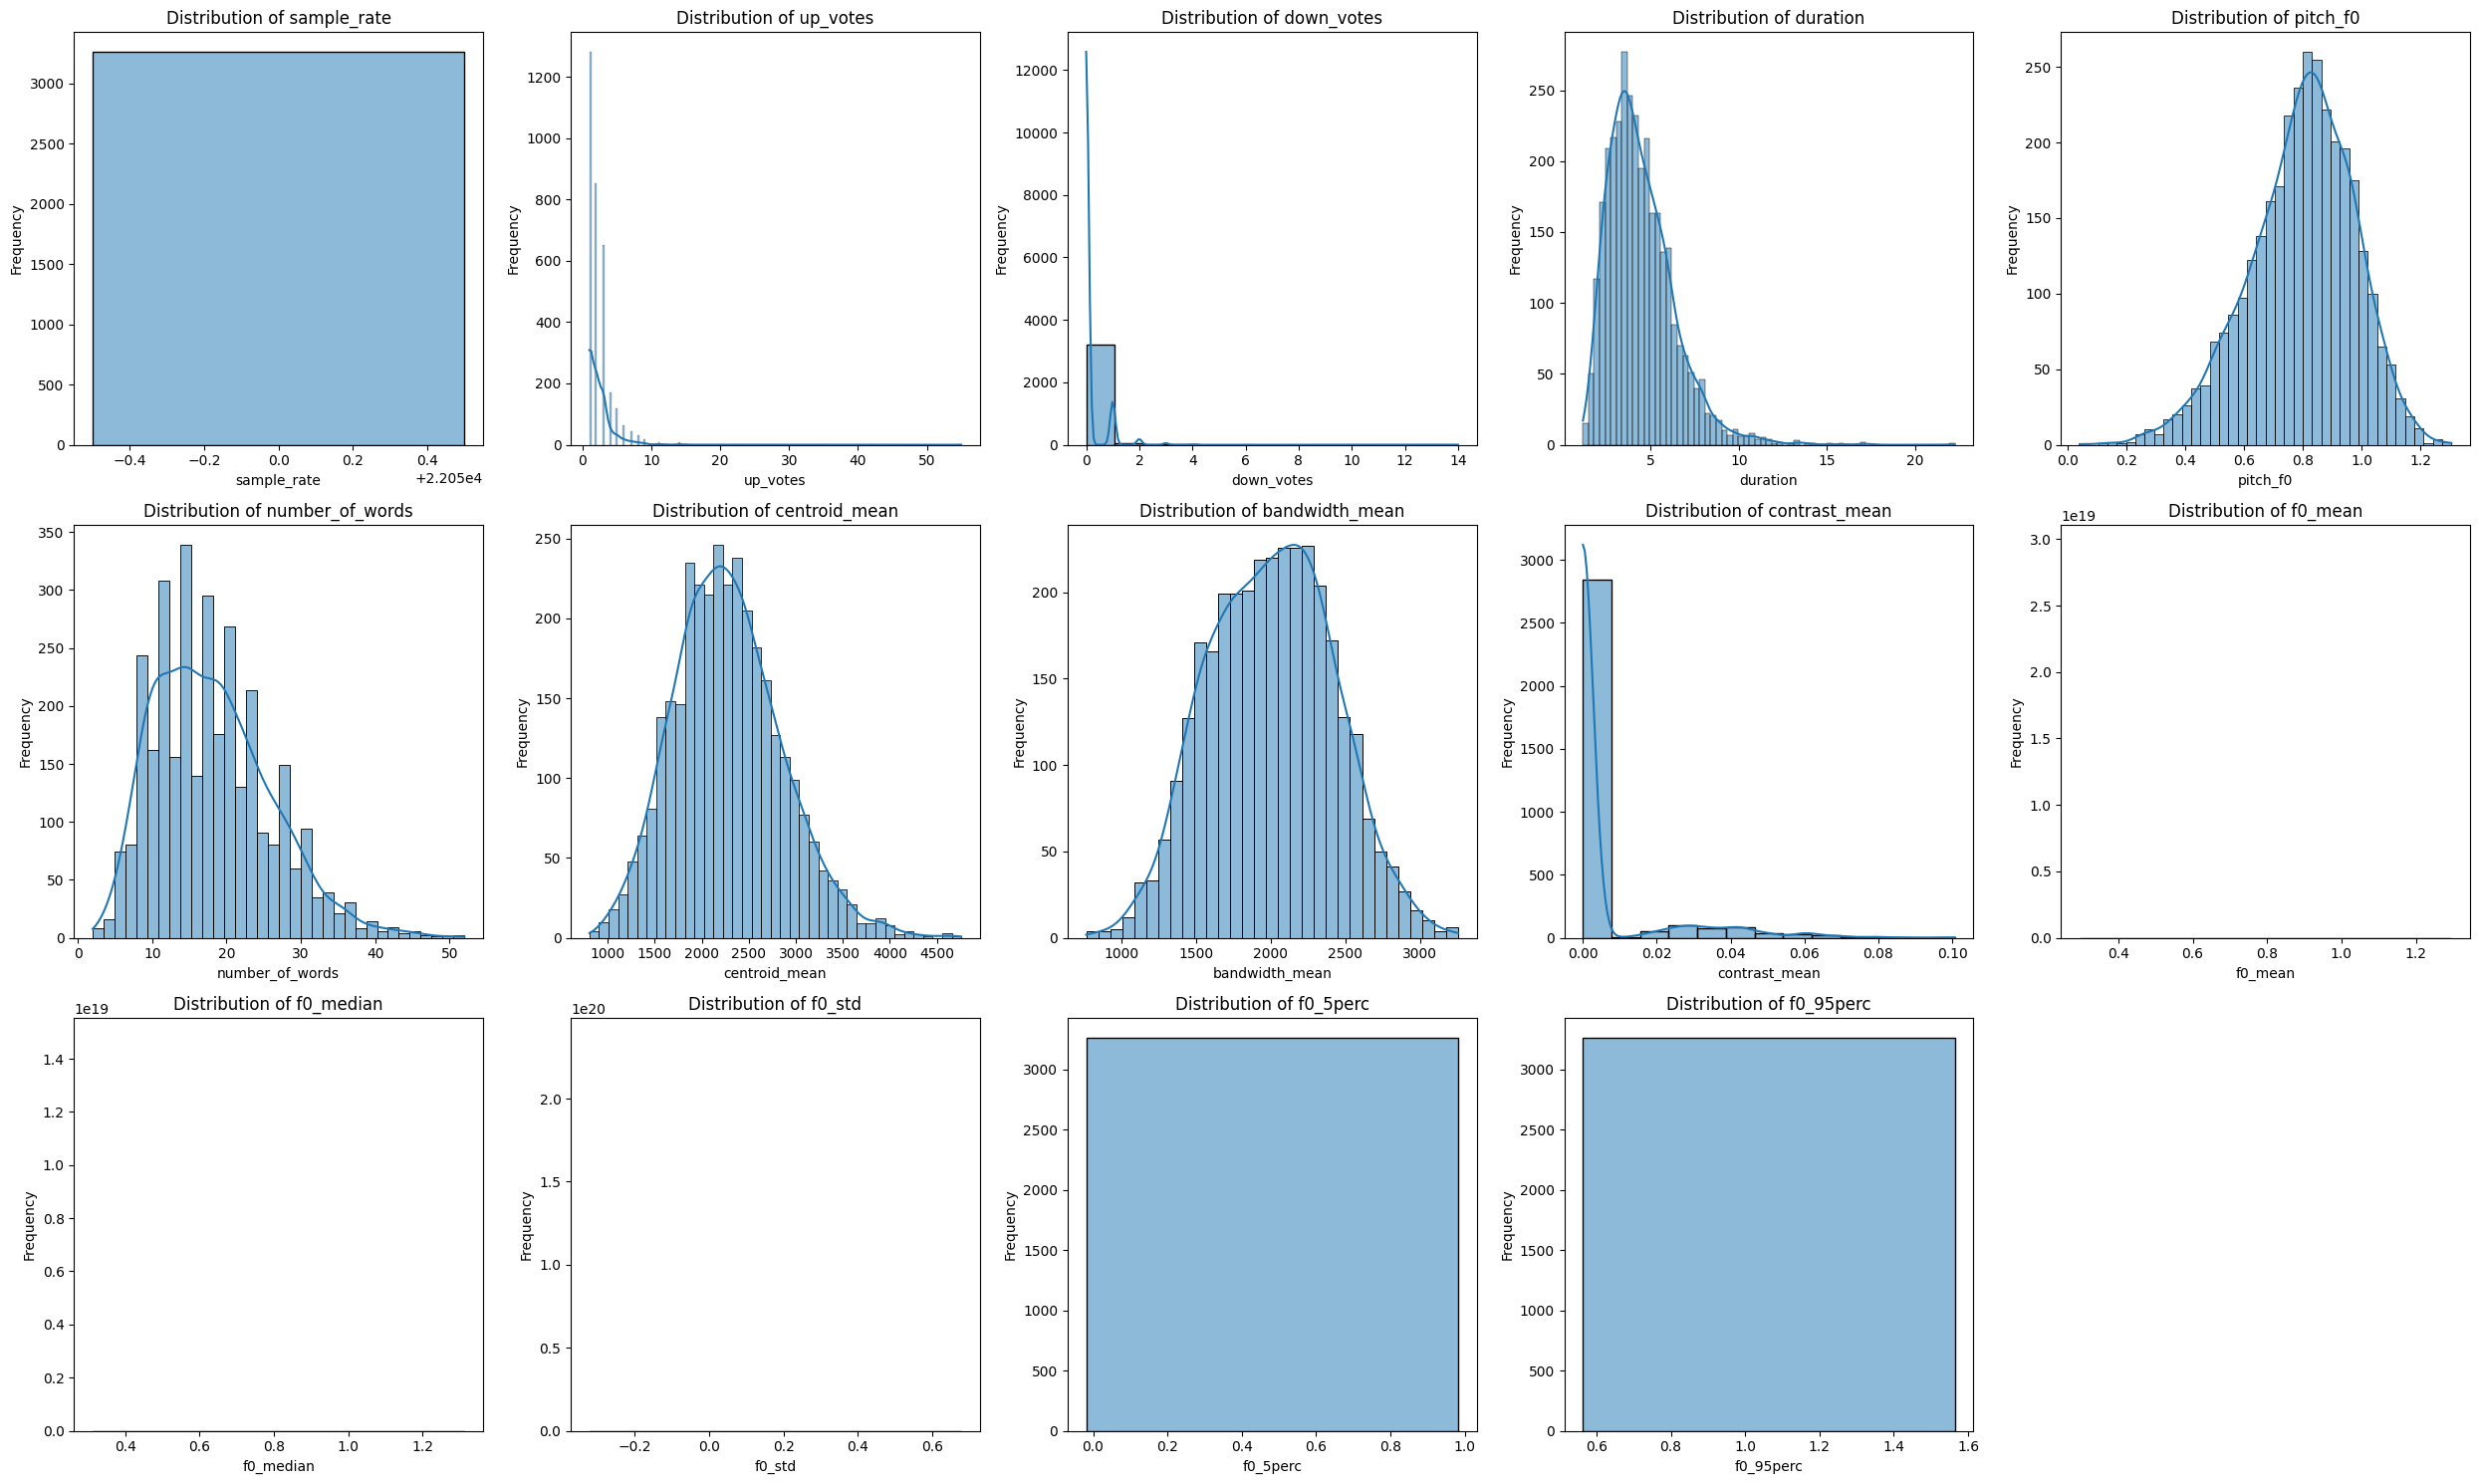

In [29]:
# Plotting histograms to visualize distribution of numerical features
plt.figure(figsize=figsize)

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(audio_data_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

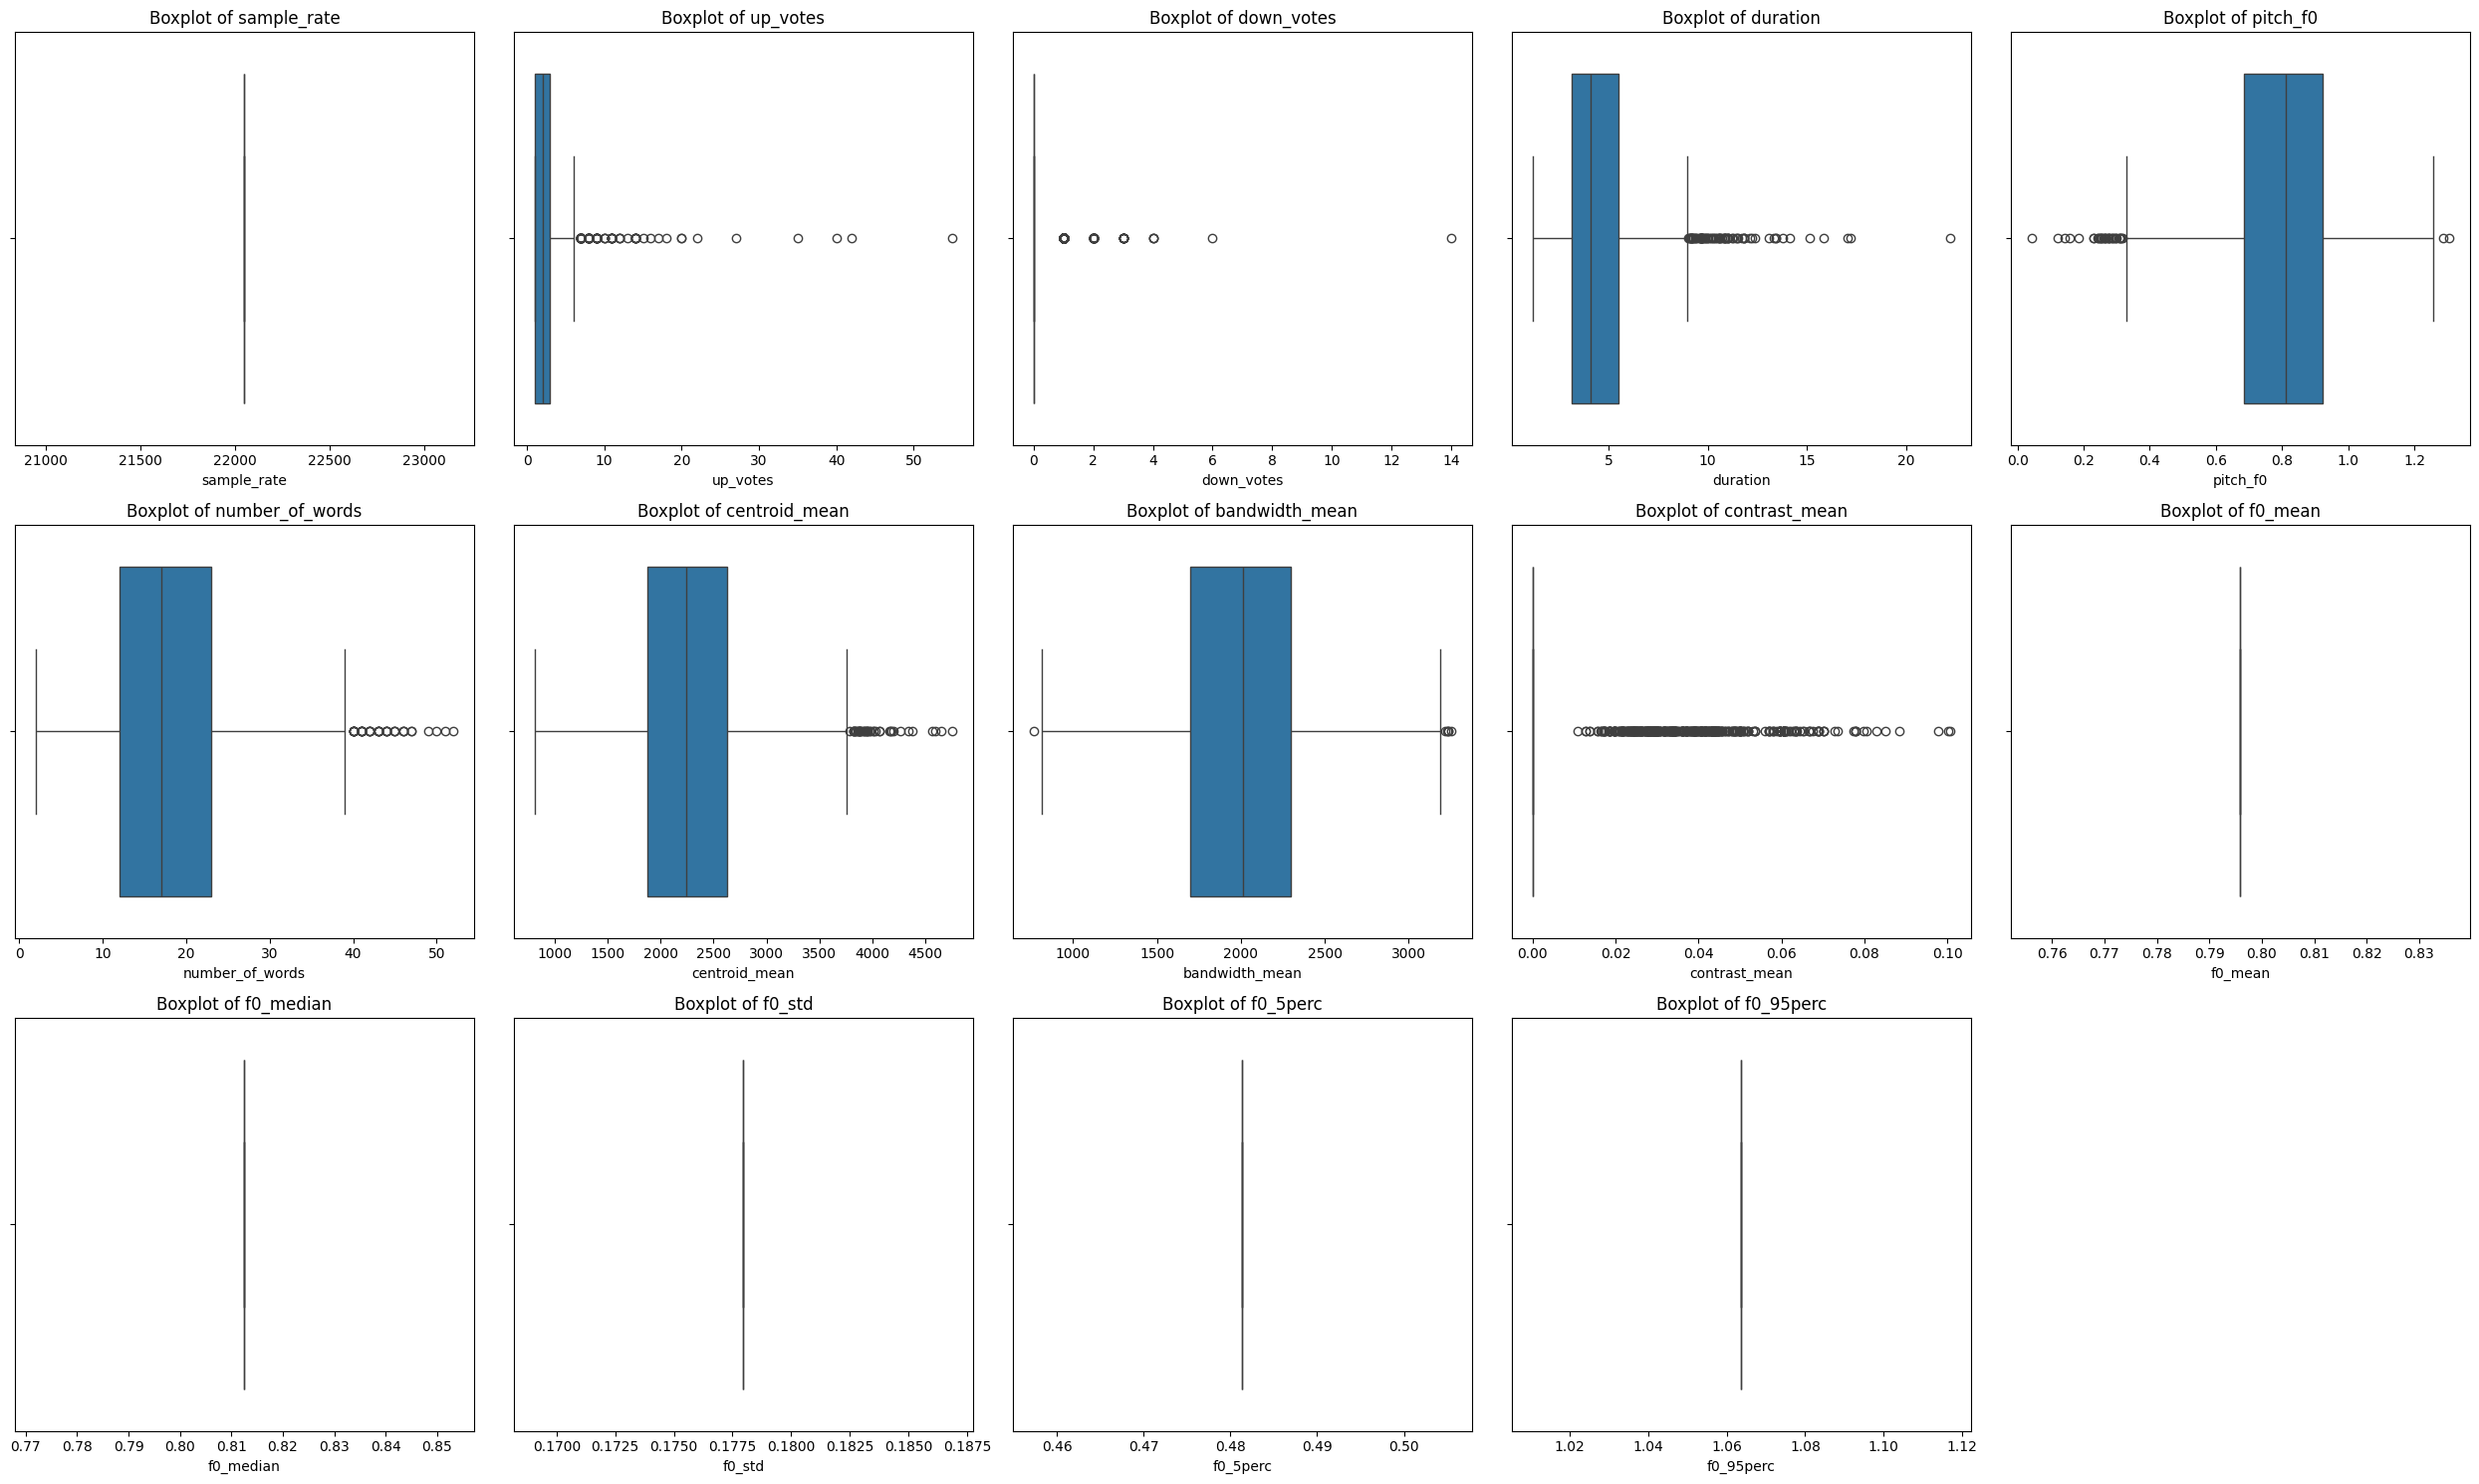

In [30]:
# Detecting outliers using boxplots
plt.figure(figsize=figsize)

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(x=audio_data_df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [31]:
# Evaluating the presence of outliers using statistical methods (e.g., IQR)
Q1 = audio_data_df[numerical_features].quantile(0.25)
Q3 = audio_data_df[numerical_features].quantile(0.75)
IQR = Q3 - Q1
outliers = ((audio_data_df[numerical_features] < (Q1 - 1.5 * IQR)) | (audio_data_df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)
num_outliers = outliers.sum()

print(f"Total number of outliers; across the numerical features: {num_outliers}")

Total number of outliers; across the numerical features: 947


In [32]:
for i, feature in enumerate(numerical_features, 1):
    Q1 = audio_data_df[feature].quantile(0.25)
    Q2 = audio_data_df[feature].median()
    Q3 = audio_data_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((audio_data_df[feature] < (Q1 - 1.5 * IQR)) | (audio_data_df[feature] > (Q3 + 1.5 * IQR)))
    num_outliers = outliers.sum()

    print(f"Statistical Analysis for the {feature} feature: ")
    print(f"> Q1; {Q1}")
    print(f"> Q2; {Q2}")
    print(f"> Q3; {Q3}")
    print(f"> Number of outliers; {num_outliers}\n")

Statistical Analysis for the sample_rate feature: 
> Q1; 22050.0
> Q2; 22050.0
> Q3; 22050.0
> Number of outliers; 0

Statistical Analysis for the up_votes feature: 
> Q1; 1.0
> Q2; 2.0
> Q3; 3.0
> Number of outliers; 128

Statistical Analysis for the down_votes feature: 
> Q1; 0.0
> Q2; 0.0
> Q3; 0.0
> Number of outliers; 377

Statistical Analysis for the duration feature: 
> Q1; 3.1440362811791385
> Q2; 4.104036281179138
> Q3; 5.496009070294784
> Number of outliers; 76

Statistical Analysis for the pitch_f0 feature: 
> Q1; 0.68418433
> Q2; 0.81255233
> Q3; 0.922561505
> Number of outliers; 33

Statistical Analysis for the number_of_words feature: 
> Q1; 12.0
> Q2; 17.0
> Q3; 23.0
> Number of outliers; 38

Statistical Analysis for the centroid_mean feature: 
> Q1; 1874.66252391548
> Q2; 2240.009672869318
> Q3; 2632.1560030162286
> Number of outliers; 40

Statistical Analysis for the bandwidth_mean feature: 
> Q1; 1696.8566786528818
> Q2; 2014.424344142472
> Q3; 2299.288155054017
> Num

#### > Data Cleaning:
- **For handling missing values:** Performing mean value imputation on the columns that have missing values

**Note:** Handling the corner case of mapping out integer based values from the categorical nature of the age column of our respective data

In [33]:
age_mapping = {
    'teens': 15,
    'twenties': 25,
    'thirties': 35,
    'fourties': 45,
    'fifties': 55,
    'sixties': 65,
    'seventies': 75,
    'eighties': 85
}

gender_mapping = {
    'male': 0,
    'female': 1,
    'other': -1
}

In [34]:
# Calculating mode values for (categorical) columns with missing values
mean_age = audio_data_df['age'].mode()[0]
mean_gender = audio_data_df['gender'].mode()[0] 
mean_accent = audio_data_df['accent'].mode()[0]  

# Imputing missing values with mode values
audio_data_df['age'].fillna(mean_age, inplace=True)
audio_data_df['gender'].fillna(mean_gender, inplace=True)
audio_data_df['accent'].fillna(mean_accent, inplace=True)

# Mapping the categorical gender labels to numerical values
audio_data_df['gender'] = audio_data_df['gender'].map(gender_mapping)
audio_data_df['gender'].fillna(-1, inplace=True)

# Mapping the categorical age labels to numerical values
audio_data_df['age'] =audio_data_df['age'].map(age_mapping)

# Converting the 'age' column to integer type
audio_data_df['age'] = audio_data_df['age'].astype(int)
audio_data_df['gender'] = audio_data_df['gender'].astype(int)

In [35]:
# Verifying that missing values have been filled
print(audio_data_df.isnull().sum())

filename           0
transcription      0
up_votes           0
down_votes         0
age                0
gender             0
accent             0
audio_data         0
sample_rate        0
duration           0
pitch_f0           0
formants           0
intensity_rms      0
mfccs              0
onsets             0
number_of_words    0
tempo              0
beats              0
mels               0
mel_strength       0
centroid_mean      0
bandwidth_mean     0
contrast_mean      0
f0_mean            0
f0_median          0
f0_std             0
f0_5perc           0
f0_95perc          0
dtype: int64


#### > Data Cleaning: (Feature based)

- Performing feature based data cleaning on the by performing the following operations:
    - Noise reduction; through noise gating
    - Audio trimming; to ensure filtering out tailing signals

In [36]:
def process_audio(row):
    audio_data, sr = librosa.load(row["filename"])

    reduced_noise = nr.reduce_noise(y=audio_data, sr=sr)
    y_trim, _ = librosa.effects.trim(audio_data, top_db=21)
    
    return pd.Series({'reduced_noise': reduced_noise, 'trimmed_audio': y_trim})

In [38]:
audio_data_df[['reduced_noise', 'trimmed_audio']] = audio_data_df.progress_apply(process_audio, axis=1)

  0%|          | 0/3264 [00:00<?, ?it/s]

In [39]:
audio_data_df.to_csv("audio_features_data_1.csv", index=False)

#### > Data Transformation:
- Following steps are performed for data tranformation
    - Scaling
    - Normalization

In [52]:
audio_data_df=pd.read_csv("audio_features_data_1.csv")

##### >> Data Scaling

**Note:** There are few consideration that were made while categorizing features (into different scaling and normzalization categorizes) for data scaling and normalizations:
- The categorization of numerical features for scaling and normalization is based on there data structuring through-out the dataset.
    - It was due to the prospect that extracted audio features is going to be fit on multiple machine learning models for
- Secondly, it was observed that the sample rate values for the audios remained constant across the data samples processed.
    - Therefore, scaling and normalizing it would remain void in concept; moreover it would be contributing very less to the model training aspect of the task currently at hand. 

In [53]:
robust_features = [
    "up_votes", "down_votes", "duration", "intensity_rms", 
    "number_of_words", "contrast_mean"
]

standard_features = [
    "pitch_f0", "centroid_mean", "bandwidth_mean"
]

In [54]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

In [55]:
for feature in robust_features:
    audio_data_df[f'{feature}_scaled'] = robust_scaler.fit_transform(audio_data_df[[feature]])

for feature in standard_features:
    audio_data_df[f'{feature}_scaled'] = standard_scaler.fit_transform(audio_data_df[[feature]])

##### >> Data Normalization

In [56]:
minmax_features = [
    "f0_mean", "f0_median", "f0_std", 
    "f0_5perc", "f0_95perc"
]

In [57]:
minmax_scaler = MinMaxScaler()

In [58]:
for feature in minmax_features:
    audio_data_df[f'{feature}_scaled'] = minmax_scaler.fit_transform(audio_data_df[[feature]])

**Note:** Now, performing log transformations to features where the data is exhibiting certain characteristics that can be better handled by compressing the range of the data. 

In [59]:
numerical_features_df = audio_data_df.select_dtypes(include=[np.number])

In [60]:
skewness = numerical_features_df.skew().sort_values(ascending=False)

print("Skewness of Features:")
print(skewness)

Skewness of Features:
down_votes_scaled         9.416206
down_votes                9.416206
up_votes                  8.250130
up_votes_scaled           8.250130
intensity_rms             8.008394
intensity_rms_scaled      8.008394
contrast_mean_scaled      3.010501
contrast_mean             3.010501
gender                    2.655375
age                       2.329950
duration_scaled           1.504315
duration                  1.504315
number_of_words           0.687140
number_of_words_scaled    0.687140
centroid_mean             0.448348
centroid_mean_scaled      0.448348
bandwidth_mean            0.030580
bandwidth_mean_scaled     0.030580
f0_std_scaled             0.000000
f0_median_scaled          0.000000
f0_mean_scaled            0.000000
f0_5perc_scaled           0.000000
f0_5perc                  0.000000
f0_95perc                 0.000000
f0_std                    0.000000
f0_median                 0.000000
f0_mean                   0.000000
sample_rate               0.00000

In [61]:
range_check = numerical_features_df.describe().loc[['min', 'max']]

print("Feature Range Check:")
print(range_check)

Feature Range Check:
     up_votes  down_votes   age  gender  sample_rate   duration  pitch_f0  \
min       1.0         0.0  15.0    -1.0      22050.0   1.176009  0.042256   
max      55.0        14.0  85.0     1.0      22050.0  22.224036  1.305469   

     intensity_rms  number_of_words  centroid_mean  ...  \
min   3.675609e+01              2.0     806.944983  ...   
max   3.355327e+07             52.0    4758.541245  ...   

     number_of_words_scaled  contrast_mean_scaled  pitch_f0_scaled  \
min               -1.363636              0.000000        -4.235489   
max                3.181818              0.100691         2.863693   

     centroid_mean_scaled  bandwidth_mean_scaled  f0_mean_scaled  \
min             -2.571981              -2.986321             0.0   
max              4.339916               3.008086             0.0   

     f0_median_scaled  f0_std_scaled  f0_5perc_scaled  f0_95perc_scaled  
min               0.0            0.0              0.0               0.0  
max  

In [63]:
# Assuming skewness is a Pandas Series with feature names as index
log_transform_candidates = skewness[skewness > 0.75].index.tolist()

# Excluding 'age' and 'gender' target features from the candidates
excluded_features = ['age', 'gender']
log_transform_candidates = [feature for feature in log_transform_candidates if feature not in excluded_features]

print("Features shortlisted for log transformation:")
print(log_transform_candidates)


Features shortlisted for log transformation:
['down_votes_scaled', 'down_votes', 'up_votes', 'up_votes_scaled', 'intensity_rms', 'intensity_rms_scaled', 'contrast_mean_scaled', 'contrast_mean', 'duration_scaled', 'duration']


In [64]:
temp_log_transformed_df = pd.DataFrame()

In [65]:
# Performing log transformation and store in the temporary DataFrame
for feature in log_transform_candidates:

    if (numerical_features_df[feature] <= 0).any():  # Handling non-positive values
        temp_log_transformed_df[feature + '_log'] = np.log(numerical_features_df[feature] + 1 - numerical_features_df[feature].min())
    else:
        temp_log_transformed_df[feature + '_log'] = np.log(numerical_features_df[feature])


In [66]:
audio_data_df = pd.concat([audio_data_df, temp_log_transformed_df], axis=1)

In [67]:
audio_data_df.to_csv("audio_features_processed.csv", index=False) 

### EDA: For the preprocessed state of data

In [68]:
audio_data_df=pd.read_csv("audio_features_processed.csv")

In [69]:
audio_data_df.head()

,filename,transcription,up_votes,down_votes,age,gender,accent,audio_data,sample_rate,duration,...,down_votes_scaled_log,down_votes_log,up_votes_log,up_votes_scaled_log,intensity_rms_log,intensity_rms_scaled_log,contrast_mean_scaled_log,contrast_mean_log,duration_scaled_log,duration_log
0,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,learn to recognize omens and follow them the o...,1,0,25,0,us,[-5.9227658e-11 1.6258904e-11 3.5964388e-11 ...,22050,4.104036,...,0.000000,0.000000,0.000000,0.000000,13.748428,0.612312,0.0,0.0,0.808672,1.411971
1,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,everything in the universe evolved he said,1,0,25,0,us,[ 1.5570863e-12 1.9885526e-12 5.0891769e-12 ...,22050,7.560000,...,0.000000,0.000000,0.000000,0.000000,7.331758,0.001346,0.0,0.0,1.312194,2.022871
2,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,you came so that you could learn about your dr...,1,0,25,0,us,[-1.5786802e-11 -4.9093251e-12 -7.5024278e-11 ...,22050,5.064036,...,0.000000,0.000000,0.000000,0.000000,13.179249,0.390739,0.0,0.0,0.975726,1.622164
3,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,so now i fear nothing because it was those ome...,1,0,25,0,us,[-1.5923391e-11 2.6508585e-11 -9.1306103e-12 ...,22050,6.648027,...,0.000000,0.000000,0.000000,0.000000,10.292947,0.026288,0.0,0.0,1.201940,1.894320
4,C:\\Users\\user\\Desktop\\Ongoing Projects\\Co...,if you start your emails with greetings let me...,3,2,25,0,us,[1.0412913e-08 9.2886254e-12 2.6633327e-09 ......,22050,4.896009,...,1.098612,1.098612,1.098612,0.693147,17.328645,3.443930,0.0,0.0,0.948429,1.588420


In [70]:
audio_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   filename                  3264 non-null   object 
 1   transcription             3264 non-null   object 
 2   up_votes                  3264 non-null   int64  
 3   down_votes                3264 non-null   int64  
 4   age                       3264 non-null   int64  
 5   gender                    3264 non-null   int64  
 6   accent                    3264 non-null   object 
 7   audio_data                3264 non-null   object 
 8   sample_rate               3264 non-null   int64  
 9   duration                  3264 non-null   float64
 10  pitch_f0                  3264 non-null   float64
 11  formants                  3264 non-null   object 
 12  intensity_rms             3264 non-null   float64
 13  mfccs                     3264 non-null   object 
 14  onsets  

In [71]:
audio_data_df.describe()

,up_votes,down_votes,age,gender,sample_rate,duration,pitch_f0,intensity_rms,number_of_words,centroid_mean,...,down_votes_scaled_log,down_votes_log,up_votes_log,up_votes_scaled_log,intensity_rms_log,intensity_rms_scaled_log,contrast_mean_scaled_log,contrast_mean_log,duration_scaled_log,duration_log
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.0,3264.000000,3264.000000,3.264000e+03,3264.000000,3264.000000,...,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,2.423407,0.143995,29.384191,0.085478,22050.0,4.470905,0.795909,1.054665e+06,18.056373,2277.370671,...,0.089669,0.089669,0.652824,0.420405,12.603898,0.479259,0.004905,0.004905,0.824824,1.414258
std,2.411972,0.497102,10.685402,0.288269,0.0,1.909480,0.177965,2.298157e+06,7.819243,571.796985,...,0.259177,0.259177,0.630081,0.436953,1.866473,0.518411,0.013845,0.013845,0.315143,0.408264
min,1.000000,0.000000,15.000000,-1.000000,22050.0,1.176009,0.042256,3.675609e+01,2.000000,806.944983,...,0.000000,0.000000,0.000000,0.000000,3.604304,0.000000,0.000000,0.000000,0.000000,0.162127
25%,1.000000,0.000000,25.000000,0.000000,22050.0,3.144036,0.684184,9.539463e+04,12.000000,1874.662524,...,0.000000,0.000000,0.000000,0.000000,11.465777,0.082630,0.000000,0.000000,0.608001,1.145507
50%,2.000000,0.000000,25.000000,0.000000,22050.0,4.104036,0.812552,3.771695e+05,17.000000,2240.009673,...,0.000000,0.000000,0.693147,0.405465,12.840449,0.293175,0.000000,0.000000,0.808672,1.411971
75%,3.000000,0.000000,25.000000,0.000000,22050.0,5.496009,0.922562,1.202405e+06,23.000000,2632.156003,...,0.000000,0.000000,1.098612,0.693147,13.999833,0.735315,0.000000,0.000000,1.042661,1.704022
max,55.000000,14.000000,85.000000,1.000000,22050.0,22.224036,1.305469,3.355327e+07,52.000000,4758.541245,...,2.708050,2.708050,4.007333,3.332205,17.328645,3.443930,0.095939,0.095939,2.297482,3.101174


**Note:** Checking for data balance

In [72]:
age_counts = audio_data_df['age'].value_counts()
gender_counts = audio_data_df['gender'].value_counts()

print("Age Distribution:\n", age_counts)
print("\nGender Distribution:\n", gender_counts)

Age Distribution:
 age
25    2465
35     285
45     184
55     140
15      88
65      69
75      28
85       5
Name: count, dtype: int64

Gender Distribution:
 gender
 0    2969
 1     287
-1       8
Name: count, dtype: int64


### Data Visualization: For the preprocessed data

In [73]:
numerical_features = audio_data_df.select_dtypes(include=['number'])

ncols = 5
num_features = 43
nrows = math.ceil(num_features / ncols)

# Setting the figure size
figsize = (ncols * 5, nrows * 5)

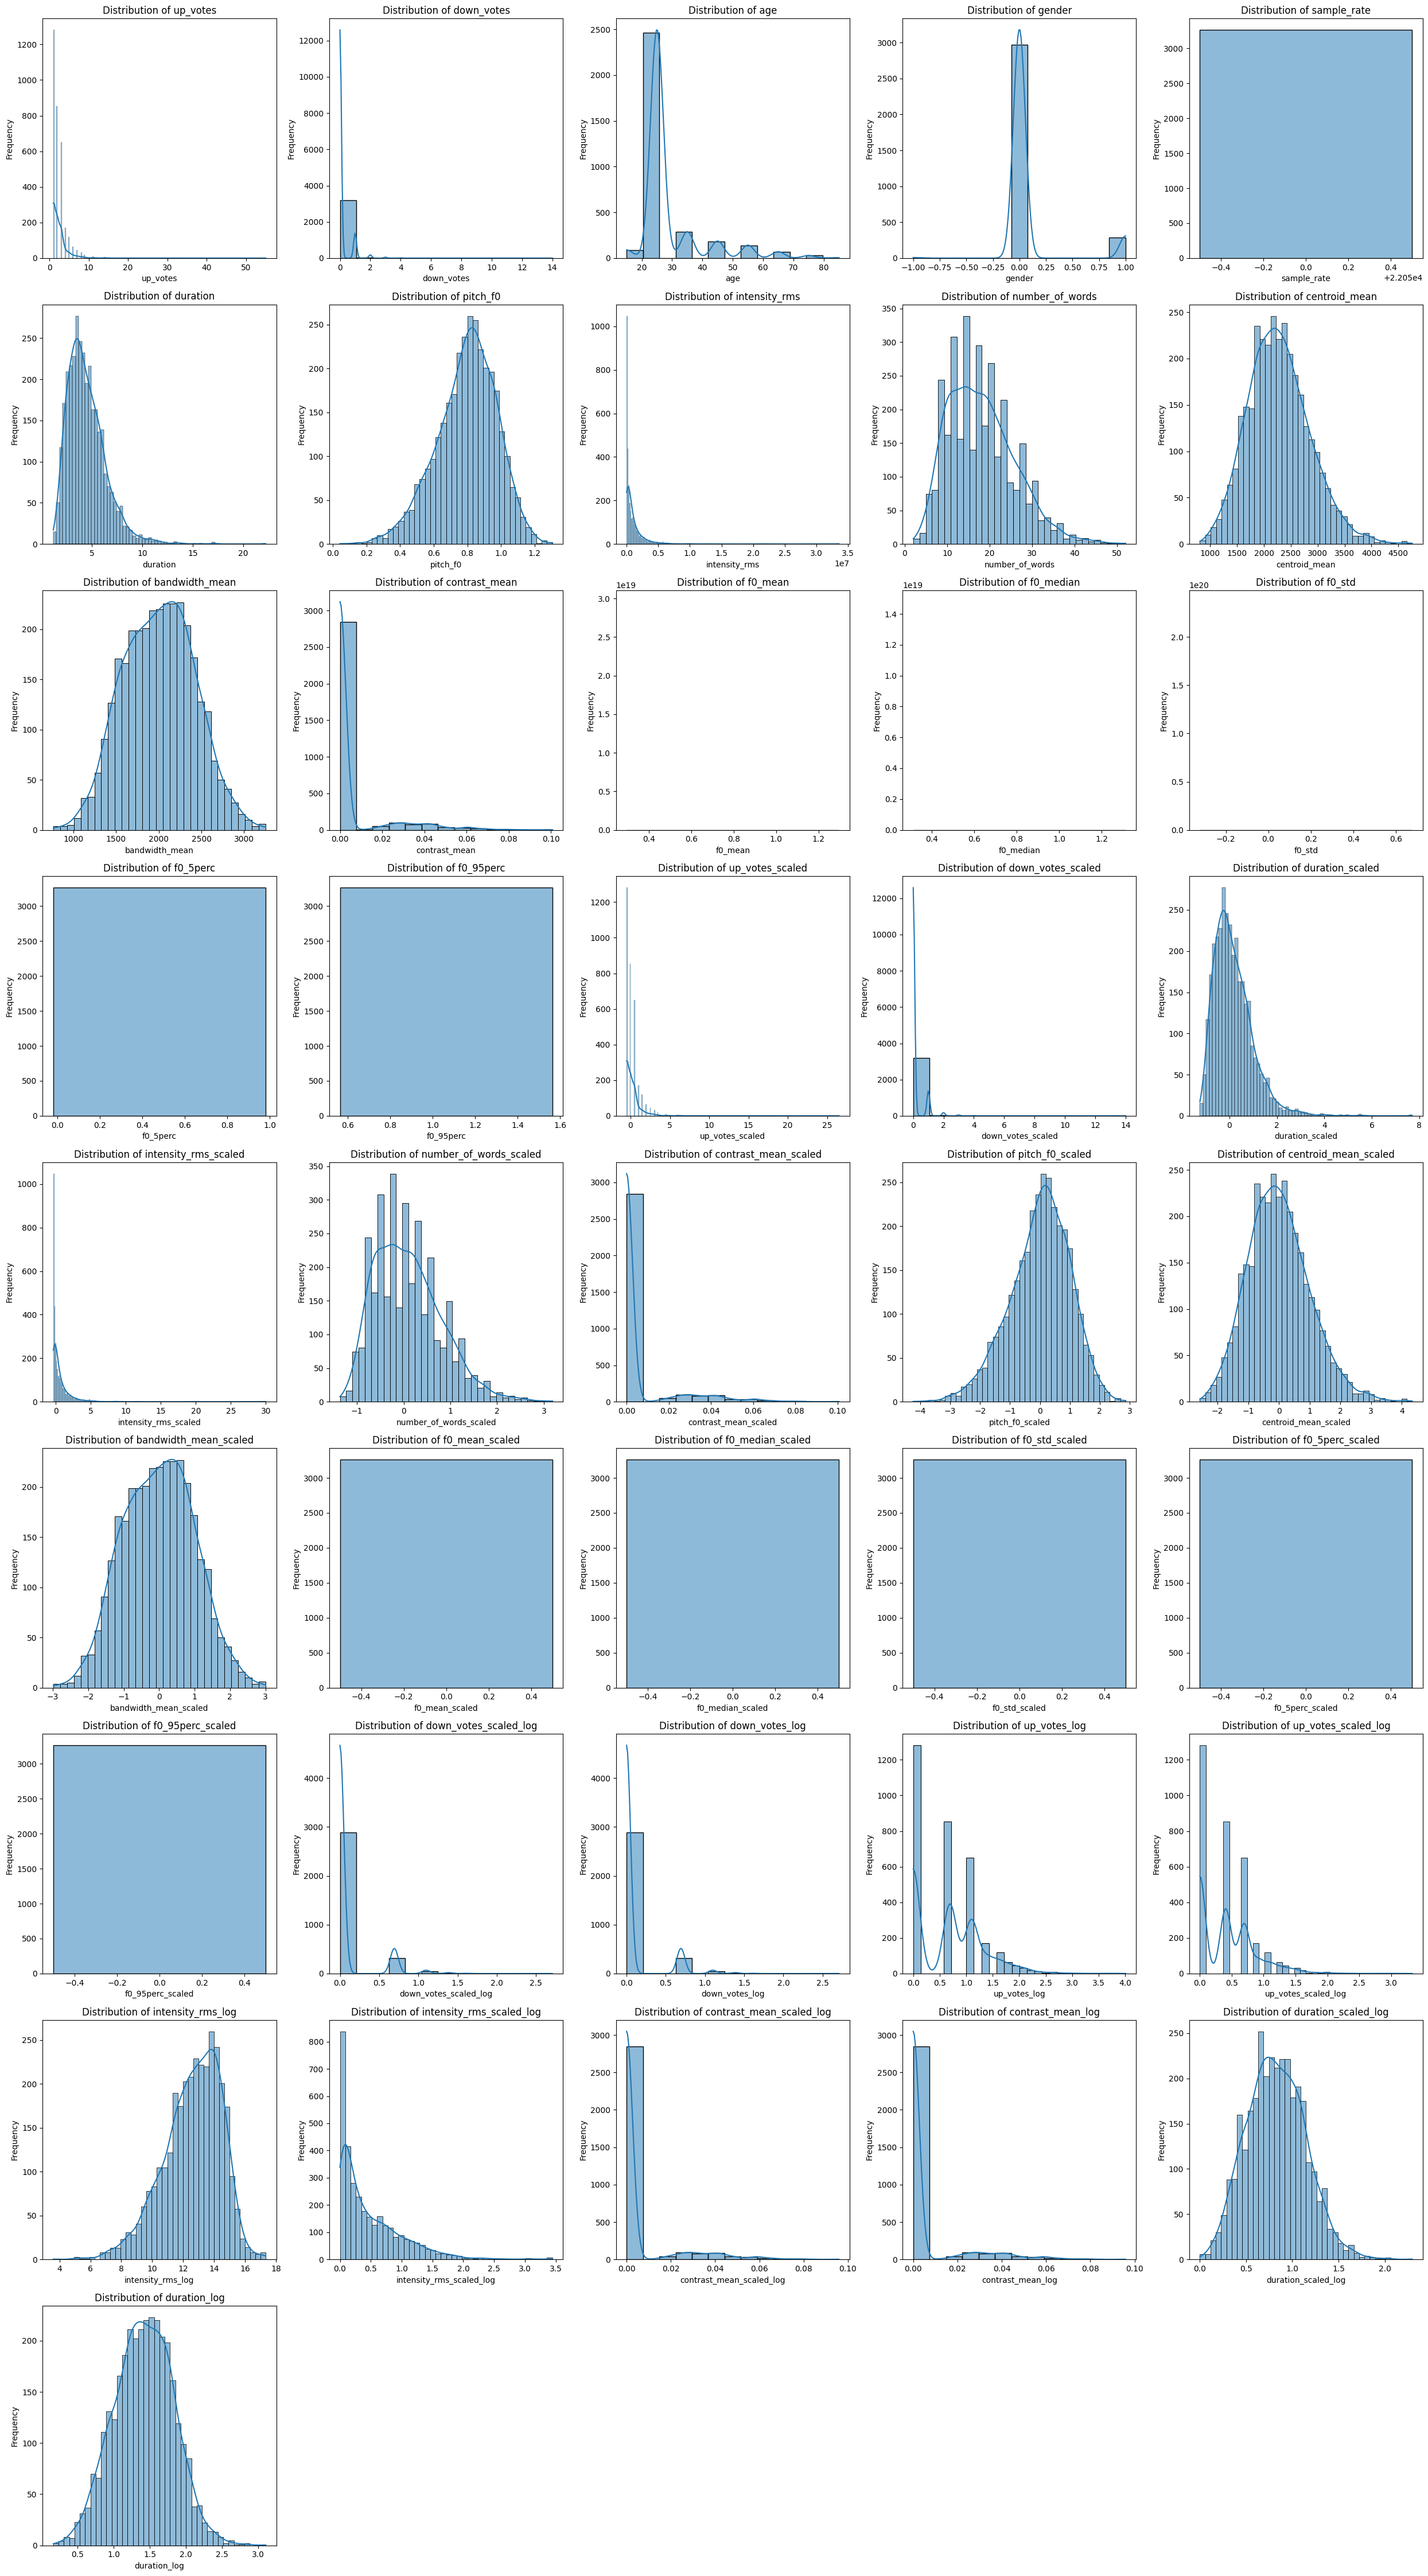

In [74]:
# Plotting histograms to visualize distribution of numerical features
plt.figure(figsize=figsize)

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(audio_data_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

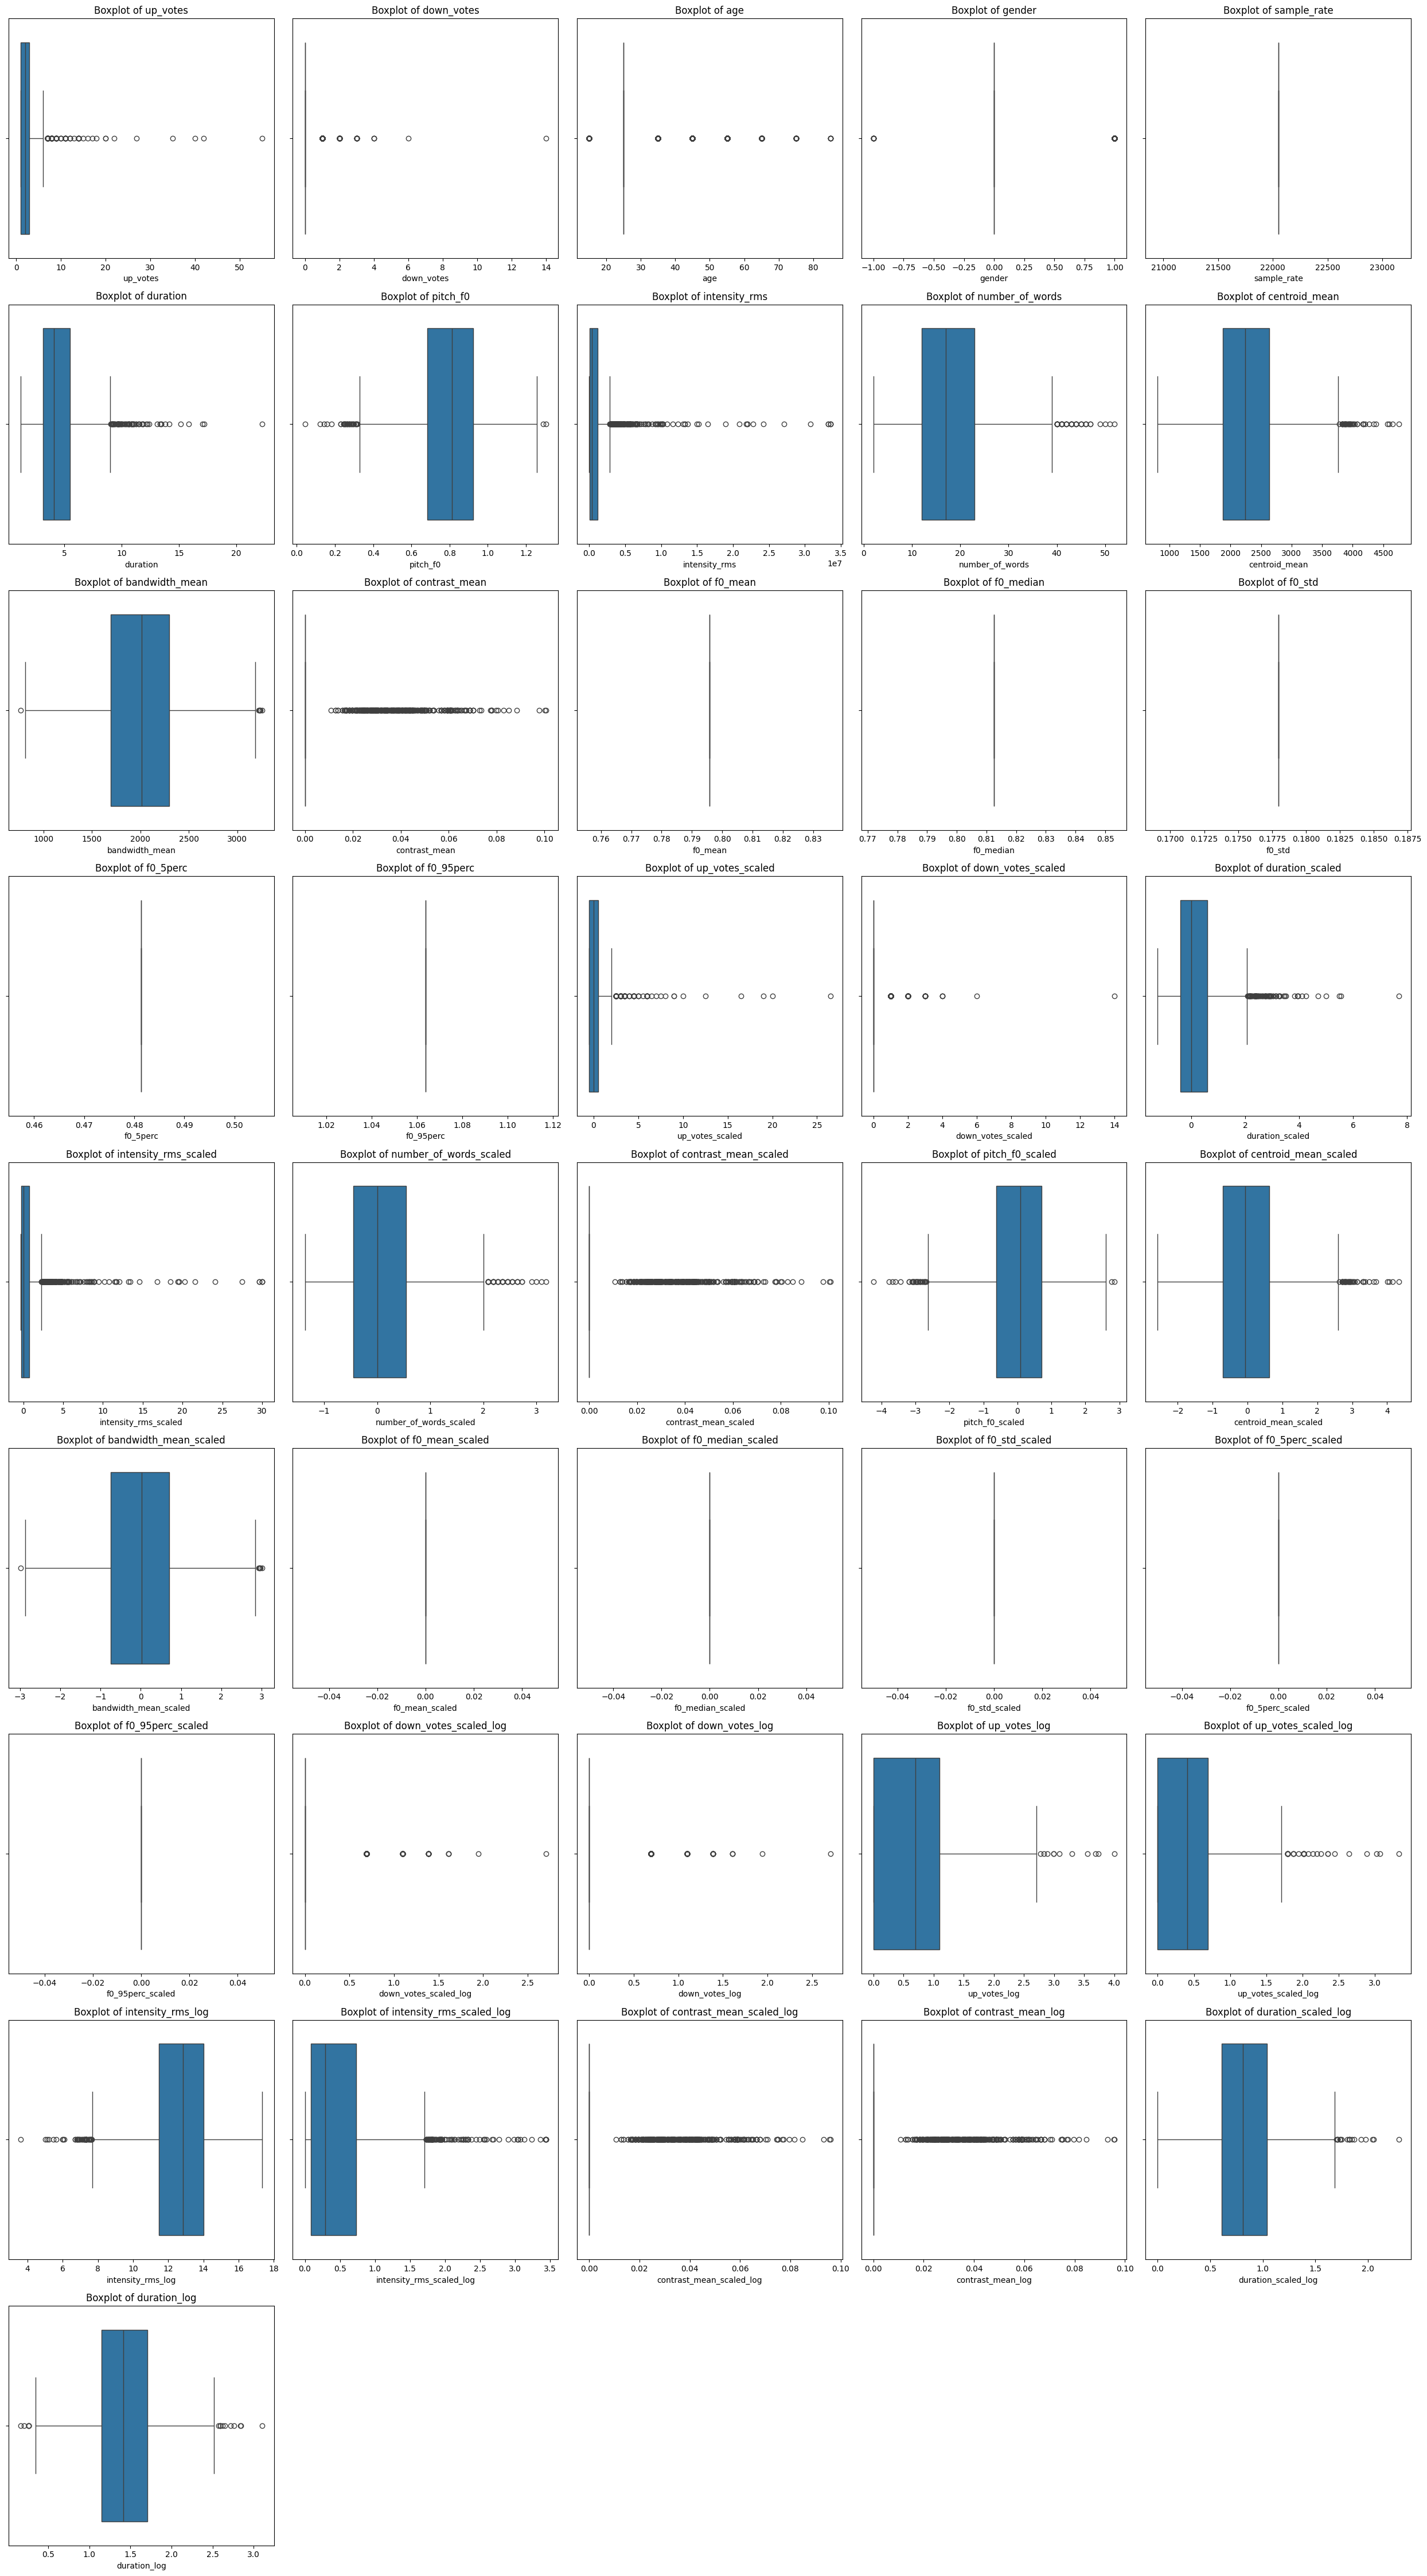

In [75]:
# Detecting outliers using boxplots
plt.figure(figsize=figsize)

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(x=audio_data_df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

In [76]:
# Initializing variables to store overall Q1, Q2 (median), and Q3 across all numerical features
overall_Q1 = 0
overall_Q2 = 0
overall_Q3 = 0
total_outliers = 0

num_features = len(numerical_features)

# Looping through each numerical feature
for i, feature in enumerate(numerical_features, 1):
    # Calculating Q1, Q2 (median), and Q3 for each feature
    Q1 = audio_data_df[feature].quantile(0.25)
    Q2 = audio_data_df[feature].median()
    Q3 = audio_data_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Accumulating overall Q1, Q2 (median), and Q3
    overall_Q1 += Q1
    overall_Q2 += Q2
    overall_Q3 += Q3
    
    # Identifying outliers for each feature
    outliers = ((audio_data_df[feature] < (Q1 - 1.5 * IQR)) | (audio_data_df[feature] > (Q3 + 1.5 * IQR)))
    num_outliers = outliers.sum()
    
    # Accumulating total number of outliers across all features
    total_outliers += num_outliers

# Calculating average Q1, Q2 (median), and Q3 across all numerical features
overall_Q1 /= num_features
overall_Q2 /= num_features
overall_Q3 /= num_features

# Printing overall statistical summary across all numerical features
print("Overall Statistical Summary across all Numerical Features:")
print(f"> Overall Q1 (Average): {overall_Q1}")
print(f"> Overall Q2 (Median Average): {overall_Q2}")
print(f"> Overall Q3 (Average): {overall_Q3}")
print(f"> Total Number of Outliers across all features: {total_outliers}")


Overall Statistical Summary across all Numerical Features:
> Overall Q1 (Average): 37.092807463041176
> Overall Q2 (Median Average): 123.63438799847266
> Overall Q3 (Average): 376.6760702825992
> Total Number of Outliers across all features: 5668


In [77]:
for i, feature in enumerate(numerical_features, 1):
    Q1 = audio_data_df[feature].quantile(0.25)
    Q2 = audio_data_df[feature].median()
    Q3 = audio_data_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((audio_data_df[feature] < (Q1 - 1.5 * IQR)) | (audio_data_df[feature] > (Q3 + 1.5 * IQR)))
    num_outliers = outliers.sum()

    print(f"Statistical Analysis for the {feature} feature: ")
    print(f"> Q1; {Q1}")
    print(f"> Q2; {Q2}")
    print(f"> Q3; {Q3}")
    print(f"> Number of outliers; {num_outliers}\n")

Statistical Analysis for the up_votes feature: 
> Q1; 1.0
> Q2; 2.0
> Q3; 3.0
> Number of outliers; 128

Statistical Analysis for the down_votes feature: 
> Q1; 0.0
> Q2; 0.0
> Q3; 0.0
> Number of outliers; 377

Statistical Analysis for the age feature: 
> Q1; 25.0
> Q2; 25.0
> Q3; 25.0
> Number of outliers; 799

Statistical Analysis for the gender feature: 
> Q1; 0.0
> Q2; 0.0
> Q3; 0.0
> Number of outliers; 295

Statistical Analysis for the sample_rate feature: 
> Q1; 22050.0
> Q2; 22050.0
> Q3; 22050.0
> Number of outliers; 0

Statistical Analysis for the duration feature: 
> Q1; 3.1440362811791385
> Q2; 4.104036281179138
> Q3; 5.496009070294784
> Number of outliers; 76

Statistical Analysis for the pitch_f0 feature: 
> Q1; 0.68418433
> Q2; 0.81255233
> Q3; 0.922561505
> Number of outliers; 33

Statistical Analysis for the intensity_rms feature: 
> Q1; 95394.633
> Q2; 377169.45499999996
> Q3; 1202404.8
> Number of outliers; 266

Statistical Analysis for the number_of_words feature: 

### Feature Engineering

#### > Feature Selection:

**Note:** Seperating the target from the features

In [80]:
X = audio_data_df.drop(columns=['age', "gender"])  
X = X.select_dtypes(include=['number'])

y = audio_data_df['age']
y_1 = audio_data_df['age']

In [81]:
print(X.columns)

Index(['up_votes', 'down_votes', 'sample_rate', 'duration', 'pitch_f0',
       'intensity_rms', 'number_of_words', 'centroid_mean', 'bandwidth_mean',
       'contrast_mean', 'f0_mean', 'f0_median', 'f0_std', 'f0_5perc',
       'f0_95perc', 'up_votes_scaled', 'down_votes_scaled', 'duration_scaled',
       'intensity_rms_scaled', 'number_of_words_scaled',
       'contrast_mean_scaled', 'pitch_f0_scaled', 'centroid_mean_scaled',
       'bandwidth_mean_scaled', 'f0_mean_scaled', 'f0_median_scaled',
       'f0_std_scaled', 'f0_5perc_scaled', 'f0_95perc_scaled',
       'down_votes_scaled_log', 'down_votes_log', 'up_votes_log',
       'up_votes_scaled_log', 'intensity_rms_log', 'intensity_rms_scaled_log',
       'contrast_mean_scaled_log', 'contrast_mean_log', 'duration_scaled_log',
       'duration_log'],
      dtype='object')


In [82]:
mi_scores = mutual_info_regression(X, y)  # Using mutual_info_regression for regression
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Top features based on Mutual Information:")
print(mi_scores_series)

Top features based on Mutual Information:
bandwidth_mean_scaled       0.052374
bandwidth_mean              0.052374
duration_scaled             0.043590
pitch_f0_scaled             0.042822
pitch_f0                    0.042822
duration                    0.033354
intensity_rms               0.029801
intensity_rms_scaled        0.029801
intensity_rms_scaled_log    0.028616
intensity_rms_log           0.028452
centroid_mean_scaled        0.025096
centroid_mean               0.025096
f0_std_scaled               0.023070
duration_scaled_log         0.022257
down_votes_scaled_log       0.021112
up_votes_scaled_log         0.018406
f0_95perc_scaled            0.014989
down_votes                  0.014264
contrast_mean_scaled        0.013940
duration_log                0.012803
contrast_mean_log           0.009524
contrast_mean               0.005483
sample_rate                 0.004899
up_votes                    0.004619
number_of_words_scaled      0.004077
contrast_mean_scaled_log    0.004

In [83]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Use RandomForestRegressor for regression

rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Top features based on Random Forest importance:")
print(feature_importances)

Top features based on Random Forest importance:
bandwidth_mean_scaled       0.065958
centroid_mean_scaled        0.064478
bandwidth_mean              0.063487
pitch_f0                    0.063012
pitch_f0_scaled             0.062201
centroid_mean               0.062178
intensity_rms               0.056978
intensity_rms_log           0.056016
intensity_rms_scaled_log    0.054781
intensity_rms_scaled        0.054542
duration                    0.047566
duration_log                0.047380
duration_scaled_log         0.047281
duration_scaled             0.046710
number_of_words_scaled      0.045335
number_of_words             0.043809
up_votes_log                0.016687
up_votes                    0.016297
up_votes_scaled_log         0.016199
up_votes_scaled             0.015854
contrast_mean               0.009742
contrast_mean_scaled        0.009709
contrast_mean_log           0.009533
contrast_mean_scaled_log    0.009329
down_votes_log              0.004128
down_votes_scaled_log      

In [84]:
# Combining MI scores and feature importance to make a final decision on feature selection
selected_features = mi_scores_series[mi_scores_series > 0].index.intersection(feature_importances[feature_importances > 0].index)

# Selecting the most relevant features
X_selected = X[selected_features]

In [85]:
X_selected.columns

Index(['bandwidth_mean_scaled', 'bandwidth_mean', 'duration_scaled',
       'pitch_f0_scaled', 'pitch_f0', 'duration', 'intensity_rms',
       'intensity_rms_scaled', 'intensity_rms_scaled_log', 'intensity_rms_log',
       'centroid_mean_scaled', 'centroid_mean', 'duration_scaled_log',
       'down_votes_scaled_log', 'up_votes_scaled_log', 'down_votes',
       'contrast_mean_scaled', 'duration_log', 'contrast_mean_log',
       'contrast_mean', 'up_votes', 'number_of_words_scaled',
       'contrast_mean_scaled_log', 'down_votes_scaled', 'up_votes_log'],
      dtype='object')

In [86]:
pca = PCA(n_components=0.95)  # Retaining 95% of the variance
X_pca = pca.fit_transform(X_selected)

print(f"Original number of features: {X_selected.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

Original number of features: 25
Reduced number of features after PCA: 1


##### >> Splitting the datasets into training and testing halfs

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_pca, y, test_size=0.2, random_state=42)

### Model Training

#### > Utility function for brute specific modelling

In [111]:
def y_pred(X_test, weights, bias):
    # Adding bias term to the feature matrix
    X_test_with_bias = np.c_[X_test, np.ones(X_test.shape[0])]

    # Performing prediction using the manually computed weights and bias
    y_pred = np.dot(X_test_with_bias, np.concatenate([weights, [bias]]))

    return y_pred

#### > Driver functions for brute specific modelling

##### >> Ridge regression approach

In [112]:
def ridge_based_brute_linear_regression(x, y, lambda_reg=1e-5):
    # Adding a column of ones for bias
    x_with_bias = np.c_[x, np.ones(x.shape[0])]

    # Calculating X transpose
    x_transpose = x_with_bias.T

    # Calculating X transpose multiplied by X
    x_transpose_x = np.dot(x_transpose, x_with_bias)

    # Adding regularization term (lambda_reg * I)
    regularization_term = lambda_reg * np.eye(x_transpose_x.shape[0])
    x_transpose_x_reg = x_transpose_x + regularization_term

    # Calculating the inverse of X_transpose_X with regularization
    x_transpose_x_inv = np.linalg.inv(x_transpose_x_reg)

    # Calculating (X_transpose_X)^-1 multiplied by X transpose
    a = np.dot(x_transpose_x_inv, x_transpose)

    # Converting y to a NumPy array and reshaping it
    y_array = y.to_numpy().reshape(-1, 1)

    # Calculating the final parameters
    final = np.dot(a, y_array)

    # Extracting weights and bias
    weights = final[:-1]
    bias = final[-1]

    return final, weights, bias

##### >> Collinearity check approach (For, testing)

In [113]:

# Utility functions
# Function to calculate VIF for each feature
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

# Function to drop features with high VIF
def drop_high_vif_features(X, threshold=5.0):
    vif = calculate_vif(X)
    print("VIF before dropping high VIF features:")
    print(vif)

    # Droping features with VIF greater than the threshold
    while vif["VIF"].max() > threshold:
        drop_feature = vif.loc[vif["VIF"].idxmax(), "features"]
        X = X.drop(columns=[drop_feature])
        vif = calculate_vif(X)

    print("\nVIF after dropping high VIF features:")
    print(vif)
    
    return X

In [114]:
# Implementation based function
def collinearity_based_brute_linear_regression(x, y):
    # Adding a column of ones for bias
    x_with_bias = np.c_[x, np.ones(x.shape[0])]

    # Calculating X transpose
    x_transpose = x_with_bias.T

    # Calculating X transpose multiplied by X
    x_transpose_x = np.dot(x_transpose, x_with_bias)

    # Calculating the inverse of X_transpose_X
    x_transpose_x_inv = np.linalg.inv(x_transpose_x)

    # Calculating (X_transpose_X)^-1 multiplied by X transpose
    a = np.dot(x_transpose_x_inv, x_transpose)

    # Converting y to a NumPy array and reshaping it
    y_array = y.to_numpy().reshape(-1, 1)

    # Calculating the final parameters
    final = np.dot(a, y_array)

    # Extracting weights and bias
    weights = final[:-1]
    bias = final[-1]

    return final, weights, bias


In [115]:
# Droping features with high VIF
X_train_reduced = drop_high_vif_features(X_train)

# Performing Linear Regression
final_params, weights, bias = collinearity_based_brute_linear_regression(X_train_reduced, y_train)

# Predicting on test set
X_test_reduced = X_test[X_train_reduced.columns]  # Ensure test set has the same columns
predicted_y = np.dot(np.c_[X_test_reduced, np.ones(X_test_reduced.shape[0])], final_params)

# Evaluating the model
rounded_y = predicted_y.astype(int)
mse = ((rounded_y - y_test.to_numpy().flatten()) ** 2).mean()

print("Model Evaluation (MSE):", mse)

c:\Program Files\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF before dropping high VIF features:
                    features          VIF
0      bandwidth_mean_scaled          inf
1             bandwidth_mean          inf
2            duration_scaled          inf
3            pitch_f0_scaled          inf
4                   pitch_f0          inf
5                   duration          inf
6              intensity_rms          inf
7       intensity_rms_scaled          inf
8   intensity_rms_scaled_log     9.126911
9          intensity_rms_log     4.218671
10      centroid_mean_scaled          inf
11             centroid_mean          inf
12       duration_scaled_log  1922.615423
13     down_votes_scaled_log     6.598061
14       up_votes_scaled_log   265.796270
15                down_votes          inf
16      contrast_mean_scaled          inf
17              duration_log  1277.012289
18         contrast_mean_log          inf
19             contrast_mean          inf
20                  up_votes     8.780981
21    number_of_words_scaled     2.47

c:\Program Files\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Program Files\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Program Files\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Program Files\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Program Files\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Program Files\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: 


VIF after dropping high VIF features:
                   features       VIF
0                  pitch_f0  1.985520
1      intensity_rms_scaled  1.127298
2      centroid_mean_scaled  1.017606
3                  up_votes  2.124884
4    number_of_words_scaled  1.088967
5  contrast_mean_scaled_log  1.132856
6         down_votes_scaled  1.250772
Model Evaluation (MSE): 105.3830360053376


##### > Training based upon brute specific approach

In [116]:
final_params, weights, bias =ridge_based_brute_linear_regression(X_train, y_train)

In [117]:
predicted_y = np.dot(np.c_[X_test, np.ones(X_test.shape[0])], final_params)

rounded_y = predicted_y.astype(int)

##### > Training based upon "sklearn" specific approach

In [118]:
model = LinearRegression()

model.fit(X_train, y_train)

train_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
test_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

### Model Evaluation

##### > Evaluation based upon brute specific approach

In [119]:
mse = ((predicted_y - y_test.to_numpy().flatten()) ** 2).mean()

print("Model Evaluation for the Brute Specific Model: ", mse)

Model Evaluation for the Brute Specific Model:  105.8944086621927


##### > Evaluation based upon "sklearn" specific approach

In [120]:
print("Model Evaluation for the 'sklearn' Specific Model")
print(f"> Train RMSE; {train_rmse}")
print(f"> Test RMSE; {test_rmse}")

predictions = model.predict(X_test)

Model Evaluation for the 'sklearn' Specific Model
> Train RMSE; 10.741728154199556
> Test RMSE; 10.183457716140778


### Model Interpretation and Insights

##### _**EDA**: For, training data results_

In [121]:
predictions_test = model.predict(X_test)

test_data_with_predictions = X_test.copy()

test_data_with_predictions=pd.DataFrame(test_data_with_predictions)

test_data_with_predictions['age_encoded'] = y_test
test_data_with_predictions['predicted_age_encoded'] = predictions_test

In [122]:
test_data_with_predictions

,bandwidth_mean_scaled,bandwidth_mean,duration_scaled,pitch_f0_scaled,pitch_f0,duration,intensity_rms,intensity_rms_scaled,intensity_rms_scaled_log,intensity_rms_log,...,duration_log,contrast_mean_log,contrast_mean,up_votes,number_of_words_scaled,contrast_mean_scaled_log,down_votes_scaled,up_votes_log,age_encoded,predicted_age_encoded
1641,0.755869,2318.152054,1.122462,-0.282130,0.745708,6.744036,2.452066e+04,-0.318560,0.021876,10.107271,...,1.908659,0.000000,0.000000,6,0.545455,0.000000,1.0,1.791759,25,27.957417
134,-0.555385,1773.828635,-0.969399,1.098746,0.991418,1.824036,8.985209e+04,-0.259544,0.078010,11.405920,...,0.601052,0.000000,0.000000,1,-0.909091,0.000000,0.0,0.000000,25,29.508381
411,0.731240,2307.928095,-1.091861,0.922188,0.960002,1.536009,1.117196e+06,0.668492,0.697721,13.926333,...,0.429188,0.000000,0.000000,2,-0.909091,0.000000,0.0,0.693147,25,29.236048
203,0.067285,2032.309506,-0.275525,-0.896501,0.636388,3.456009,5.426851e+05,0.149516,0.398905,13.204285,...,1.240114,0.042988,0.043926,1,0.000000,0.042988,0.0,0.000000,35,30.958508
889,0.726578,2305.992873,-0.469409,1.364073,1.038630,3.000000,7.962892e+03,-0.333517,0.007134,8.982547,...,1.098612,0.000000,0.000000,9,0.181818,0.000000,0.0,2.197225,25,30.034244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,-0.070633,1975.057301,-0.306126,0.228802,0.836622,3.384036,2.180912e+06,1.629382,1.088582,14.595254,...,1.219069,0.043853,0.044828,1,-0.272727,0.043853,0.0,0.000000,25,30.035590
2608,-0.874831,1641.221516,0.367347,1.228151,1.014444,4.968027,8.380233e+04,-0.265009,0.072942,11.336216,...,1.603023,0.000000,0.000000,3,-0.272727,0.000000,0.0,1.098612,25,29.620937
2947,-0.880259,1638.968334,-0.591851,-1.922119,0.453892,2.712018,7.709148e+05,0.355684,0.528485,13.555333,...,0.997693,0.000000,0.000000,7,-0.545455,0.000000,0.0,1.945910,25,29.434739
817,-1.041370,1572.088391,1.275525,-1.307716,0.563217,7.104036,2.082999e+05,-0.152546,0.172382,12.246734,...,1.960663,0.000000,0.000000,1,1.636364,0.000000,0.0,0.000000,25,29.678467


In [123]:
# Making predictions using the linear regression model
y_pred = np.dot(X_test, weights) + bias

# Rounding the predictions to the nearest integer as age is typically an integer value
y_pred_rounded = np.round(y_pred)

# Converting the predicted and actual values to integers for comparison
y_pred_rounded = y_pred_rounded.astype(int)
y_test = y_test.astype(int)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rounded)

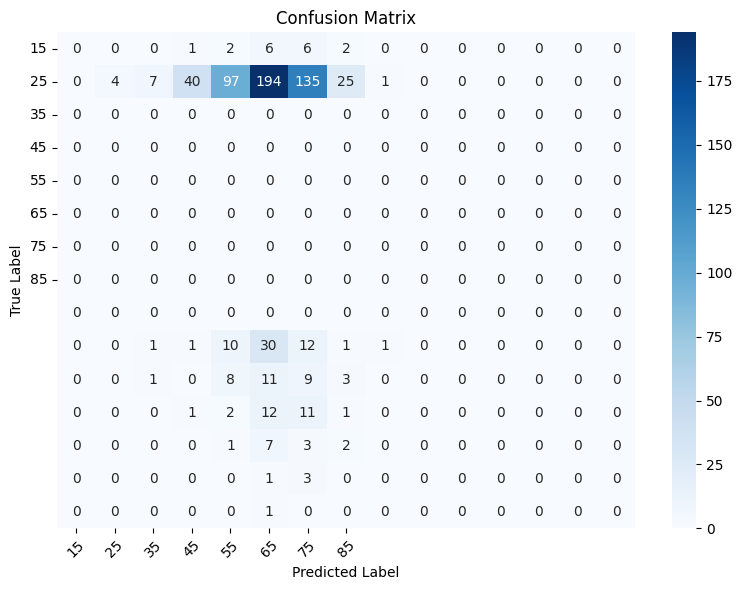

In [124]:
# Creating the confusion matrix
conf_matrix = confusion_matrix(y_test, rounded_y)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

##### > Training simulation
- Optimizer: Gradient Descent

In [125]:
# Defining the gradient descent function
def gradient_descent(m, b, data, lr):
    N = float(len(data))
    
    m_gradient = 0
    b_gradient = 0
    
    for i in range(len(data)):
        x = data[i, 0]
        y = data[i, 1]
        m_gradient += -(2/N) * x * (y - (m*x + b))
        b_gradient += -(2/N) * (y - (m*x + b))
    
    new_m = m - (lr * m_gradient)
    new_b = b - (lr * b_gradient)
    
    return new_m, new_b

# Defining the loss function (mean squared error)
def loss_function(m, b, data):
    total_error = 0
    
    for i in range(len(data)):
        x = data[i, 0]
        y = data[i, 1]
        total_error += (y - (m*x + b))**2
    
    return total_error / float(len(data))

# Defining the plot_data function to visualize the data and the fitted line
def plot_data(m, b, data):
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data Points')
    plt.plot(data[:, 0], m*data[:, 0] + b, color='red', label='Fitted Line')
    plt.title('Linear Regression with Gradient Descent')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

data=X

# Initializing the values of m and b to 0
m = 0
b = 0

# Setting the learning rate and number of epochs for gradient descent
lr = 0.0001
epochs = 500

Epoch 0 - Error: 16.1883415898116


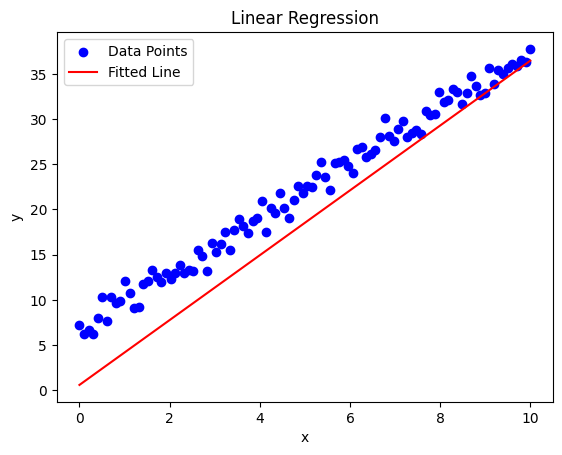

Epoch 50 - Error: 6.897525667900701


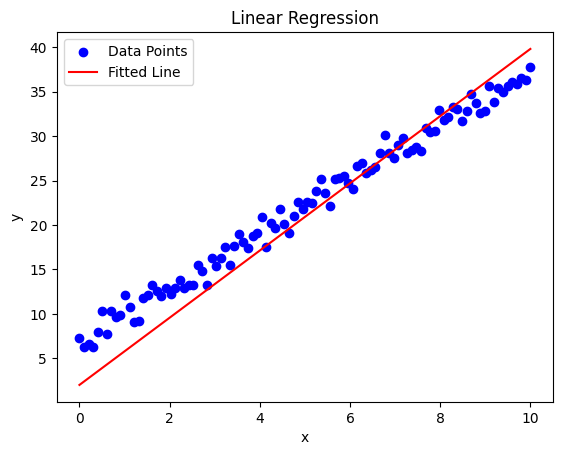

Epoch 100 - Error: 4.5851210720248865


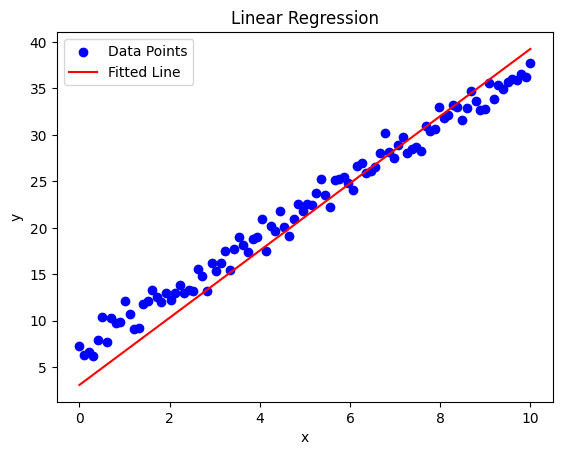

Epoch 150 - Error: 3.179254886726763


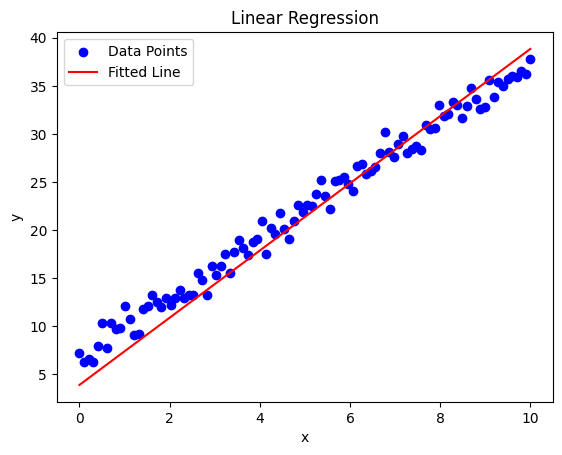

Epoch 200 - Error: 2.3245343354487926


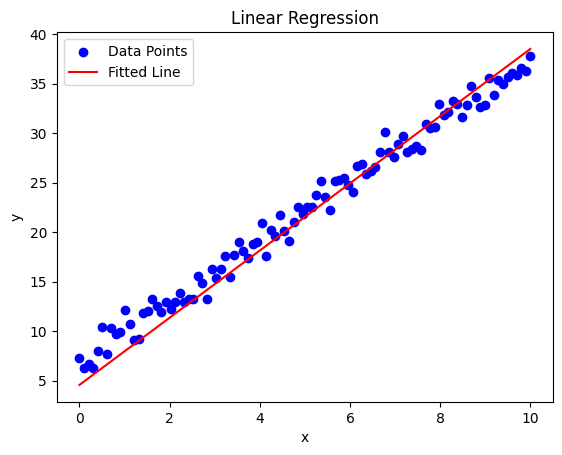

Epoch 250 - Error: 1.8048922611058473


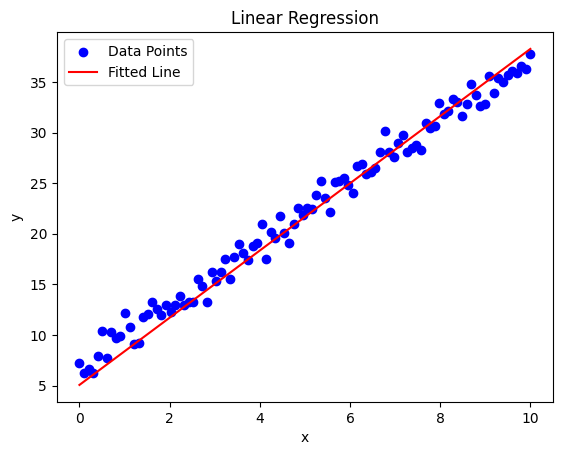

KeyboardInterrupt: Interrupted by user

In [128]:
# Performing gradient descent for the specified number of epochs
for i in range(epochs):
    # Updating m and b using gradient descent
    m, b = gradient_descent(m, b, data, lr)

    # With every 50 epochs, plot the data and the current line being fit to the data
    if i % 50 == 0:
        print("Epoch {0} - Error: {1}".format(i, loss_function(m, b, data)))
        plot_data(m, b, data)
        plt.show()
        input('Press enter to continue...')

print("m = {0}, b = {1}".format(m, b))